In [1]:
%pylab inline
import calin.ix.scripts.compute_diagnostics
import calin.io.sql_transceiver
import calin.diagnostics.waveform
import calin.diagnostics.functional
from calin.plotting import plot_histogram
from matplotlib.backends.backend_pdf import PdfPages
import calin.iact_data.telescope_data_source
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
import calin.calib.spe_fit
import calin.calib.pmt_ses_models
import calin.math.data_modeling
import calin.math.optimizer
import calin.iact_data.llr
import calin.plotting
import csv
import os
import pickle
from xml.etree import ElementTree as ET
import calin.SPEFit as SPEFit
import matplotlib.gridspec as gridspec

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3/dist-packages/matplotlib/__init__.py:1352: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# Extract Charge histogram from a fits.fz file


Launch the script compute_diagnostics to compute signal in a window of 16 ns from the sample 17 to 40 of the run 0856 and 0857, extract voltage informations from xml

In [2]:
#!command compute_diagnostics.py -help
runid = ["853","854","855","856","857","858","861"]
#runid = ["856"]

for run in runid:
    print(runid)
    commandString = "compute_diagnostics.py -decoder.camera_type=NECTARCAM -window_size=16 -sig_window_start=17 -bkg_window_start=40 \
    -o=/CTA/diagnostics"+run+".sqlite /CTA/dataCEA/NectarCAM.Run0"+run+".0000.fits.fz"
    os.system(commandString)

drawerList = []
for run in runid: 
    tree = ET.parse('/CTA/dataCEA/NectarCAM.Run0'+run+'.NMC.xml')
    root = tree.getroot()
    for drawer in root.findall('drawer'):
        print(drawer.tag)
        print(drawer.attrib['number'])
        drawerList.append(drawer.attrib['number'])
print(drawerList)

VoltageTable = np.arange(len(runid)*(len(drawerList)/len(runid))*7).reshape(len(runid),(len(drawerList)/len(runid)),7)
for i in range(len(runid)): 
    tree = ET.parse('/CTA/dataCEA/NectarCAM.Run0'+runid[i]+'.NMC.xml')
    root = tree.getroot()
    k = 0
    for HVPA in root.findall('drawer/HVPA'):
        for j in range(7):
            print('voltage'+str(j))
            print(float(HVPA.attrib['voltage'+str(j)]))
            VoltageTable[i,k,j] = float(HVPA.attrib['voltage'+str(j)])
        k = k+1
#print(VoltageTable)

['853', '854', '855', '856', '857', '858', '861']
['853', '854', '855', '856', '857', '858', '861']
['853', '854', '855', '856', '857', '858', '861']
['853', '854', '855', '856', '857', '858', '861']
['853', '854', '855', '856', '857', '858', '861']
['853', '854', '855', '856', '857', '858', '861']
['853', '854', '855', '856', '857', '858', '861']
drawer
114
drawer
115
drawer
116
drawer
149
drawer
150
drawer
151
drawer
114
drawer
115
drawer
116
drawer
149
drawer
150
drawer
151
drawer
114
drawer
115
drawer
116
drawer
149
drawer
150
drawer
151
drawer
114
drawer
115
drawer
116
drawer
149
drawer
150
drawer
151
drawer
114
drawer
115
drawer
116
drawer
149
drawer
150
drawer
151
drawer
114
drawer
115
drawer
116
drawer
149
drawer
150
drawer
151
drawer
114
drawer
115
drawer
116
drawer
149
drawer
150
drawer
151
['114', '115', '116', '149', '150', '151', '114', '115', '116', '149', '150', '151', '114', '115', '116', '149', '150', '151', '114', '115', '116', '149', '150', '151', '114', '115', '116'

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Extract the signal information from a runid vector and create a calin histogram vector Histogram

In [3]:
diagnostics = []
signal = []
for i in range(len(runid)): 
    sql = calin.io.sql_transceiver.SQLite3Transceiver("/CTA/diagnostics"+runid[i]+".sqlite",
      calin.io.sql_transceiver.SQLite3Transceiver.READ_ONLY)
    diagnostics.append(calin.ix.scripts.compute_diagnostics.Results())
    sql.retrieve_by_oid("diagnostics_results", 1, diagnostics[i])
    del sql
    signal.append(diagnostics[i].sig_stats())

Only Module ?  and ? are used in the following

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  


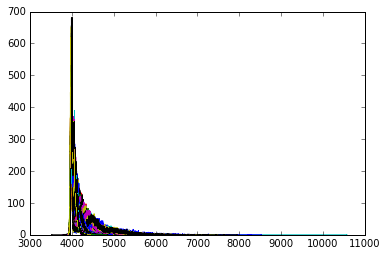

In [4]:
Histogram = []
Module = []
runTable = []
HVTable = []
DrawerTable = []
ModuleMin = 3
ModuleMax = 4

for i in range (len(runid)):
    for j in range (ModuleMin*7,ModuleMax*7):
        Histogram.append(calin.math.histogram.SimpleHist(signal[i].high_gain().value_hist(j)))
        Module.append(j)
        runTable.append(runid[i])
        HVTable.append(VoltageTable[i,int(j/7),((j/7)-int(j/7)+0.01)*7])
        DrawerTable.append(drawerList[int(j/7)])
        plot_histogram(Histogram[-1])

# Extract Charge histogram from an ASCII file

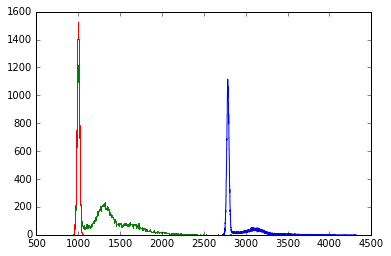

In [5]:
Filename = ["spectrum_spe_ch0_1300V"]
Path = ""

scale=1

DataListSignalToulouse = []

for i in range(len(Filename)):
    data = np.loadtxt(Path+Filename[i]+'.txt', delimiter=',', skiprows=5)
    dx = np.median(data[1:,0] - data[0:-1,0])/scale
    DataListSignalToulouse.append(calin.math.histogram.SimpleHist(dx))
    DataListSignalToulouse[-1].insert_two_vec(data[:,0]/scale, data[:,1])
    plot_histogram(DataListSignalToulouse[-1])
    
FilenamePedestal = ["resultsPedestal090620181500_585"]
FilenameSignal = ["resultsSignal090620181500_585"]
Path = ""

scale=1

DataListSignalPalaiseau = []
DataListPedestalPalaiseau = []

for i in range(len(FilenamePedestal)):
    data = np.loadtxt(Path+FilenameSignal[i]+'.txt', delimiter=',', skiprows=5)
    dx = np.median(data[1:,0] - data[0:-1,0])/scale
    DataListSignalPalaiseau.append(calin.math.histogram.SimpleHist(dx))
    DataListSignalPalaiseau[-1].insert_two_vec(1000+data[:,0]/scale, data[:,1])
    plot_histogram(DataListSignalPalaiseau[-1])
    
for i in range(len(FilenamePedestal)):
    data = np.loadtxt(Path+FilenamePedestal[i]+'.txt', delimiter=',', skiprows=5)
    dx = np.median(data[1:,0] - data[0:-1,0])/scale
    DataListPedestalPalaiseau.append(calin.math.histogram.SimpleHist(dx))
    DataListPedestalPalaiseau[-1].insert_two_vec(1000+data[:,0]/scale, data[:,1])
    plot_histogram(DataListPedestalPalaiseau[-1])


In [6]:
results2G = []
uncertainty2G = []
pedestal2G = []
ses2G = []
mes2G = []
gain2G = []
deltaGain2G = []
Param2G = []
deltaParam2G = []

results2GRobust = []
uncertainty2GRobust = []
pedestal2GRobust = []
ses2GRobust = []
mes2GRobust = []
gain2GRobust = []
deltaGain2GRobust = []
Param2GRobust = []
deltaParam2GRobust = []

resultsG = []
uncertaintyG = []
pedestalG = []
sesG = []
mesG = []
gainG = []
varG = []
deltaGainG = []
ResolutionG = []
UncertaintyResolutionG = []

for i in range(len(Histogram)):
#for i in range(1):
    a,b,c,d,e,f,g,h,l = SPEFit.Fit_2_gauss(Histogram[i]) #Simple fit with Gaussian pedestal + 2gauss spe
    #a,b,c,d,e,f,g,h,l = SPEFit.Fit_2_gauss(Histogram[i],RobustMode=True) # Fit in robust mode /!\ can be quite long
    
    #a,b,c,d,e = SPEFit.Fit_2_gauss(Histogram[i],hped=HistogramPedestal[i],UseHped=True) # if Hped used 
    results2G.append(a)
    uncertainty2G.append(b)
    mes2G.append(c)
    ses2G.append(d)
    pedestal2G.append(e)
    Param2G.append(f)
    deltaParam2G.append(g)
    gain2G.append(h)
    deltaGain2G.append(l)
    
    #Simple fit with Gaussian pedestal + 2gauss spe, all parameters of the model are free
    #Since Robust mode is engaged, this can be long
    #a,b,c,d,e,f,g,h,l = SPEFit.Fit_2_gauss(Histogram[i],RobustMode=True,FreeMode=True) 
    
    #results2GRobust.append(a)
    #uncertainty2GRobust.append(b)
    #mes2GRobust.append(c)
    #ses2GRobust.append(d)
    #pedestal2GRobust.append(e)
    #Param2GRobust.append(f)
    #deltaParam2GRobust.append(g)
    #gain2GRobust.append(h)
    #deltaGain2GRobust.append(l)
    
    a,b,c,d,e = SPEFit.Fit_1_gauss(Histogram[i])
    resultsG.append(a)
    uncertaintyG.append(b)
    mesG.append(c)
    sesG.append(d)
    pedestalG.append(e)
    gainG.append(sum(mesG[-1].all_ses_x() * mesG[-1].single_electron_spectrum())*Histogram[i].dxval())
    varG.append(sum(mesG[-1].all_ses_x()**2 * mesG[-1].single_electron_spectrum())*Histogram[i].dxval()-gainG[-1]**2)
    deltaGainG.append(uncertaintyG[-1][3])
    ResolutionG.append(resultsG[-1][4]/resultsG[-1][3])
    UncertaintyResolutionG.append(uncertaintyG[-1][4]/resultsG[-1][3])
    
results2GToulouse = []
uncertainty2GToulouse = []
pedestal2GToulouse = []
ses2GToulouse = []
mes2GToulouse = []
gain2GToulouse = []
deltaGain2GToulouse = []
Param2GToulouse = []
deltaParam2GToulouse = []

resultsGToulouse = []
uncertaintyGToulouse = []
pedestalGToulouse = []
sesGToulouse = []
mesGToulouse = []
gainGToulouse = []
varGToulouse = []
deltaGainGToulouse = []
ResolutionGToulouse = []
UncertaintyResolutionGToulouse = []

#fit Toulouse data

for i in range(len(DataListSignalToulouse)):
#for i in range(1):
    
    a,b,c,d,e,f,g,h,l = SPEFit.Fit_2_gauss(DataListSignalToulouse[i]) 
    
    
    results2GToulouse.append(a)
    uncertainty2GToulouse.append(b)
    mes2GToulouse.append(c)
    ses2GToulouse.append(d)
    pedestal2GToulouse.append(e)
    Param2GToulouse.append(f)
    deltaParam2GToulouse.append(g)
    gain2GToulouse.append(h)
    deltaGain2GToulouse.append(l)
    
    
    a,b,c,d,e = SPEFit.Fit_1_gauss(DataListSignalToulouse[i])
    resultsGToulouse.append(a)
    uncertaintyGToulouse.append(b)
    mesGToulouse.append(c)
    sesGToulouse.append(d)
    pedestalGToulouse.append(e)
    gainGToulouse.append(sum(mesG[-1].all_ses_x() * mesG[-1].single_electron_spectrum())*Histogram[i].dxval())
    varGToulouse.append(sum(mesG[-1].all_ses_x()**2 * mesG[-1].single_electron_spectrum())*Histogram[i].dxval()-gainG[-1]**2)
    deltaGainGToulouse.append(uncertaintyG[-1][3])
    ResolutionGToulouse.append(resultsG[-1][4]/resultsG[-1][3])
    UncertaintyResolutionGToulouse.append(uncertaintyG[-1][4]/resultsG[-1][3])

results2GPalaiseau = []
uncertainty2GPalaiseau = []
pedestal2GPalaiseau = []
ses2GPalaiseau = []
mes2GPalaiseau = []
gain2GPalaiseau = []
deltaGain2GPalaiseau = []
Param2GPalaiseau = []
deltaParam2GPalaiseau = []

resultsGPalaiseau = []
uncertaintyGPalaiseau = []
pedestalGPalaiseau = []
sesGPalaiseau = []
mesGPalaiseau = []
gainGPalaiseau = []
varGPalaiseau = []
deltaGainGPalaiseau = []
ResolutionGPalaiseau = []
UncertaintyResolutionGPalaiseau = []

#fit LLR data
for i in range(len(DataListSignalPalaiseau)):
#for i in range(1):
    a,b,c,d,e,f,g,h,l = SPEFit.Fit_2_gauss(DataListSignalPalaiseau[i],DataListPedestalPalaiseau[i]) 
    
    results2GPalaiseau.append(a)
    uncertainty2GPalaiseau.append(b)
    mes2GPalaiseau.append(c)
    ses2GPalaiseau.append(d)
    pedestal2GPalaiseau.append(e)
    Param2GPalaiseau.append(f)
    deltaParam2GPalaiseau.append(g)
    gain2GPalaiseau.append(h)
    deltaGain2GPalaiseau.append(l)
    
    
    a,b,c,d,e = SPEFit.Fit_1_gauss(DataListSignalPalaiseau[i],DataListPedestalPalaiseau[i])
    resultsGPalaiseau.append(a)
    uncertaintyGPalaiseau.append(b)
    mesGPalaiseau.append(c)
    sesGPalaiseau.append(d)
    pedestalGPalaiseau.append(e)
    gainGPalaiseau.append(sum(mesG[-1].all_ses_x() * mesG[-1].single_electron_spectrum())*Histogram[i].dxval())
    varGPalaiseau.append(sum(mesG[-1].all_ses_x()**2 * mesG[-1].single_electron_spectrum())*Histogram[i].dxval()-gainG[-1]**2)
    deltaGainGPalaiseau.append(uncertaintyG[-1][3])
    ResolutionGPalaiseau.append(resultsG[-1][4]/resultsG[-1][3])
    UncertaintyResolutionGPalaiseau.append(uncertaintyG[-1][4]/resultsG[-1][3])


[1, 3987.5289944057854, 20.01060375880428, 0.45, 0, 0.485, 191.0, 0.715]
3
3
Remove parameter : 0
4
3
Remove parameter : 1
7
3
Remove parameter : 4
iv2
[1, 3987.5289944057854, 20.01060375880428, 0.485, 191.0]
Resolution param :  0.485
 Limits are : 
[  1.01000000e+02   5.42600000e+03   2.02107098e+03   5.82000000e-01
   1.92910000e+04]
[  9.99200722e-16   3.91300000e+03   2.13162821e-14   3.88000000e-01
   1.98951966e-13]
 INFO  Optimization using Limited-memory BFGS (L-BFGS) (local, derivative-based) (requires: gradient)
 INFO  - stopping criteria: dF < 1e-07 or T_wall > 60 sec
 INFO  - function: N_dim = 5, provides: gradient
 INFO  List of function dimensions: 
 INFO  - # Name                Initial val  Lo bound Hi bound Stepsize
 INFO  - 0 light_intensity     1            9.99201e-16 101      0.0001  
 INFO  - 1 ped.mean            3987.53      3913     5426     0.398753
 INFO  - 2 ped.rms             20.0106      2.13163e-14 2021.07  0.00200106
 INFO  - 3 ses.resolution      0.485

2   1 303948.81822152 303948.81822152  -1149.60168742 -3.782e-03     0.055
5   1 303701.15080801 303701.15080801   -247.66741352 -8.155e-04     0.125
6   1 303465.40028716 303465.40028716   -235.75052085 -7.769e-04     0.150
7   1 303395.08051870 303395.08051870    -70.31976846 -2.318e-04     0.172
8   1 303191.79304883 303191.79304883   -203.28746987 -6.705e-04     0.194
9   1 302694.03806590 302694.03806590   -497.75498293 -1.644e-03     0.211
10  1 301667.57480973 301667.57480973  -1026.46325617 -3.403e-03     0.229
11  1 299995.02751413 299995.02751413  -1672.54729560 -5.575e-03     0.244
12  1 297980.01385658 297980.01385658  -2015.01365755 -6.762e-03     0.259
14  1 297505.74085329 297505.74085329   -474.27300329 -1.594e-03     0.290
15  1 297163.21882715 297163.21882715   -342.52202614 -1.153e-03     0.309
16  1 297023.90526769 297023.90526769   -139.31355946 -4.690e-04     0.328
17  1 296911.51082443 296911.51082443   -112.39444326 -3.785e-04     0.347
18  1 296793.25958197 296

4   1 299612.72516783 299612.72516783    -15.17014667 -5.063e-05     0.107
5   1 299603.91855225 299603.91855225     -8.80661558 -2.939e-05     0.132
6   1 299602.85481675 299602.85481675     -1.06373549 -3.550e-06     0.154
7   1 299570.94787994 299570.94787994    -31.90693682 -1.065e-04     0.172
8   1 299506.89241948 299506.89241948    -64.05546046 -2.139e-04     0.193
9   1 299156.92056485 299156.92056485   -349.97185462 -1.170e-03     0.212
10  1 299136.91117532 299136.91117532    -20.00938953 -6.689e-05     0.233
11  1 299136.16427616 299136.16427616     -0.74689916 -2.497e-06     0.252
12  1 299135.45870970 299135.45870970     -0.70556646 -2.359e-06     0.273
13  1 299130.42821174 299130.42821174     -5.03049797 -1.682e-05     0.291
14  1 299120.64971824 299120.64971824     -9.77849349 -3.269e-05     0.313
15  1 299089.61567181 299089.61567181    -31.03404644 -1.038e-04     0.334
16  1 299088.17199134 299088.17199134     -1.44368047 -4.827e-06     0.354
17  1 299088.16701371 299

[ 0.00503781  0.12446254  0.09834927  0.52937141  0.41393176]
299402.62300166383
2
[1, 3988.9187656219956, 17.853277220009058, 0.45, 0, 0.485, 165.0, 0.715]
3
3
Remove parameter : 0
4
3
Remove parameter : 1
7
3
Remove parameter : 4
iv2
[1, 3988.9187656219956, 17.853277220009058, 0.485, 165.0]
Resolution param :  0.485
 Limits are : 
[  1.01000000e+02   5.11700000e+03   1.80318100e+03   5.82000000e-01
   1.66650000e+04]
[  9.99200722e-16   3.92900000e+03   1.77635684e-14   3.88000000e-01
   1.70530257e-13]
 INFO  Optimization using Limited-memory BFGS (L-BFGS) (local, derivative-based) (requires: gradient)
 INFO  - stopping criteria: dF < 1e-07 or T_wall > 60 sec
 INFO  - function: N_dim = 5, provides: gradient
 INFO  List of function dimensions: 
 INFO  - # Name                Initial val  Lo bound Hi bound Stepsize
 INFO  - 0 light_intensity     1            9.99201e-16 101      0.0001  
 INFO  - 1 ped.mean            3988.92      3929     5117     0.398892
 INFO  - 2 ped.rms         

Resolution param :  0.485
 Limits are : 
[  1.01000000e+02   5.03400000e+03   1.79550017e+03   5.82000000e-01
   1.56550000e+04]
[  9.99200722e-16   3.92700000e+03   1.77635684e-14   3.88000000e-01
   1.42108547e-13]
 INFO  Optimization using Limited-memory BFGS (L-BFGS) (local, derivative-based) (requires: gradient)
 INFO  - stopping criteria: dF < 1e-07 or T_wall > 60 sec
 INFO  - function: N_dim = 5, provides: gradient
 INFO  List of function dimensions: 
 INFO  - # Name                Initial val  Lo bound Hi bound Stepsize
 INFO  - 0 light_intensity     1            9.99201e-16 101      0.0001  
 INFO  - 1 ped.mean            3987.49      3927     5034     0.398749
 INFO  - 2 ped.rms             17.7772      1.77636e-14 1795.5   0.00177772
 INFO  - 3 ses.resolution      0.485        0.388    0.582    4.85e-05
 INFO  - 4 ses.mean_high_gauss 155          1.42109e-13 15655    0.0155  
1   1 296362.88324870 296362.88324870            -inf       -inf     0.018
3   1 296231.81248936 296

[1, 3977.6227287589331, 18.189554927425945, 0.45, 0, 0.485, 182.0, 0.715]
3
3
Remove parameter : 0
4
3
Remove parameter : 1
7
3
Remove parameter : 4
iv2
[1, 3977.6227287589331, 18.189554927425945, 0.485, 182.0]
Resolution param :  0.485
 Limits are : 
[  1.01000000e+02   5.28500000e+03   1.83714505e+03   5.82000000e-01
   1.83820000e+04]
[  9.99200722e-16   3.90300000e+03   1.77635684e-14   3.88000000e-01
   1.70530257e-13]
 INFO  Optimization using Limited-memory BFGS (L-BFGS) (local, derivative-based) (requires: gradient)
 INFO  - stopping criteria: dF < 1e-07 or T_wall > 60 sec
 INFO  - function: N_dim = 5, provides: gradient
 INFO  List of function dimensions: 
 INFO  - # Name                Initial val  Lo bound Hi bound Stepsize
 INFO  - 0 light_intensity     1            9.99201e-16 101      0.0001  
 INFO  - 1 ped.mean            3977.62      3903     5285     0.397762
 INFO  - 2 ped.rms             18.1896      1.77636e-14 1837.15  0.00181896
 INFO  - 3 ses.resolution      0.4

Resolution param :  0.485
 Limits are : 
[  1.01000000e+02   5.32500000e+03   1.68146775e+03   5.82000000e-01
   1.70690000e+04]
[  9.99200722e-16   3.91900000e+03   1.77635684e-14   3.88000000e-01
   1.70530257e-13]
 INFO  Optimization using Limited-memory BFGS (L-BFGS) (local, derivative-based) (requires: gradient)
 INFO  - stopping criteria: dF < 1e-07 or T_wall > 60 sec
 INFO  - function: N_dim = 5, provides: gradient
 INFO  List of function dimensions: 
 INFO  - # Name                Initial val  Lo bound Hi bound Stepsize
 INFO  - 0 light_intensity     1            9.99201e-16 101      0.0001  
 INFO  - 1 ped.mean            3987.76      3919     5325     0.398776
 INFO  - 2 ped.rms             16.6482      1.77636e-14 1681.47  0.00166482
 INFO  - 3 ses.resolution      0.485        0.388    0.582    4.85e-05
 INFO  - 4 ses.mean_high_gauss 169          1.7053e-13 17069    0.0169  
1   1 300734.41993561 300734.41993561            -inf       -inf     0.033
3   1 300708.02993164 3007

1   1 320469.55513922 320469.55513922            -inf       -inf     0.037
3   1 320414.89781021 320414.89781021    -54.65732901 -1.706e-04     0.102
4   1 320394.57647535 320394.57647535    -20.32133486 -6.343e-05     0.132
5   1 320388.11271253 320388.11271253     -6.46376282 -2.017e-05     0.162
6   1 320387.28993395 320387.28993395     -0.82277859 -2.568e-06     0.191
7   1 320373.18092498 320373.18092498    -14.10900896 -4.404e-05     0.222
8   1 320344.53069993 320344.53069993    -28.65022506 -8.944e-05     0.250
9   1 319912.48178144 319912.48178144   -432.04891848 -1.351e-03     0.283
10  1 319900.38526472 319900.38526472    -12.09651673 -3.781e-05     0.313
11  1 319899.40985602 319899.40985602     -0.97540870 -3.049e-06     0.343
12  1 319897.51163764 319897.51163764     -1.89821838 -5.934e-06     0.372
13  1 319882.11591580 319882.11591580    -15.39572184 -4.813e-05     0.401
14  1 319862.69962766 319862.69962766    -19.41628814 -6.070e-05     0.431
15  1 319846.51759937 319

[ 0.00493043  0.13663207  0.10843657  0.97853495  0.73307954]
320459.22248883924
2
[1, 3981.4291067215618, 18.737347714728674, 0.45, 0, 0.485, 214.0, 0.715]
3
3
Remove parameter : 0
4
3
Remove parameter : 1
7
3
Remove parameter : 4
iv2
[1, 3981.4291067215618, 18.737347714728674, 0.485, 214.0]
Resolution param :  0.485
 Limits are : 
[  1.01000000e+02   5.73800000e+03   1.89247212e+03   5.82000000e-01
   2.16140000e+04]
[  9.99200722e-16   3.90300000e+03   1.77635684e-14   3.88000000e-01
   2.27373675e-13]
 INFO  Optimization using Limited-memory BFGS (L-BFGS) (local, derivative-based) (requires: gradient)
 INFO  - stopping criteria: dF < 1e-07 or T_wall > 60 sec
 INFO  - function: N_dim = 5, provides: gradient
 INFO  List of function dimensions: 
 INFO  - # Name                Initial val  Lo bound Hi bound Stepsize
 INFO  - 0 light_intensity     1            9.99201e-16 101      0.0001  
 INFO  - 1 ped.mean            3981.43      3903     5738     0.398143
 INFO  - 2 ped.rms         

1   1 322026.68421959 322026.68421959            -inf       -inf     0.034
2   1 321186.27420838 321186.27420838   -840.41001122 -2.617e-03     0.067
5   1 320933.71424498 320933.71424498   -252.55996340 -7.870e-04     0.207
6   1 320772.03179223 320772.03179223   -161.68245275 -5.040e-04     0.240
7   1 320652.33464086 320652.33464086   -119.69715137 -3.733e-04     0.275
8   1 320309.22505098 320309.22505098   -343.10958988 -1.071e-03     0.306
9   1 319528.87333371 319528.87333371   -780.35171727 -2.442e-03     0.339
10  1 317970.32435772 317970.32435772  -1558.54897599 -4.902e-03     0.371
11  1 315809.50813830 315809.50813830  -2160.81621941 -6.842e-03     0.404
13  1 315290.75216617 315290.75216617   -518.75597213 -1.645e-03     0.470
14  1 314160.24763185 314160.24763185  -1130.50453433 -3.598e-03     0.502
15  1 314008.47813065 314008.47813065   -151.76950120 -4.833e-04     0.534
16  1 313981.37592710 313981.37592710    -27.10220356 -8.632e-05     0.567
17  1 313971.31110027 313

[  1.01000000e+02   5.84300000e+03   1.01502921e+03   5.82000000e-01
   2.54881531e+04]
[  9.99200722e-16   3.91200000e+03   1.06581410e-14   3.88000000e-01
   2.55795385e-13]
 INFO  Optimization using Limited-memory BFGS (L-BFGS) (local, derivative-based) (requires: gradient)
 INFO  - stopping criteria: dF < 1e-07 or T_wall > 60 sec
 INFO  - function: N_dim = 5, provides: gradient
 INFO  List of function dimensions: 
 INFO  - # Name                Initial val  Lo bound Hi bound Stepsize
 INFO  - 0 light_intensity     1            9.99201e-16 101      0.0001  
 INFO  - 1 ped.mean            3969.44      3912     5843     0.396944
 INFO  - 2 ped.rms             10.0498      1.06581e-14 1015.03  0.00100498
 INFO  - 3 ses.resolution      0.485        0.388    0.582    4.85e-05
 INFO  - 4 ses.mean_high_gauss 252.358      2.55795e-13 25488.2  0.0252358
1   1 325595.64884589 325595.64884589            -inf       -inf     0.028
2   1 324489.54768853 324489.54768853  -1106.10115737 -3.409e-03 

3   1 308995.02133632 308995.02133632    -59.06910991 -1.912e-04     0.077
4   1 308978.76886212 308978.76886212    -16.25247420 -5.260e-05     0.099
5   1 308970.88364653 308970.88364653     -7.88521559 -2.552e-05     0.119
6   1 308970.13714795 308970.13714795     -0.74649858 -2.416e-06     0.140
7   1 308954.41370168 308954.41370168    -15.72344628 -5.089e-05     0.161
8   1 308922.15493747 308922.15493747    -32.25876420 -1.044e-04     0.187
9   1 308678.04997270 308678.04997270   -244.10496477 -7.908e-04     0.210
10  1 308673.79508257 308673.79508257     -4.25489013 -1.378e-05     0.237
11  1 308673.36974320 308673.36974320     -0.42533937 -1.378e-06     0.262
12  1 308672.30800944 308672.30800944     -1.06173376 -3.440e-06     0.287
13  1 308668.71907938 308668.71907938     -3.58893006 -1.163e-05     0.320
14  1 308661.94222944 308661.94222944     -6.77684994 -2.196e-05     0.360
15  1 308650.59117105 308650.59117105    -11.35105839 -3.678e-05     0.394
16  1 308639.89973879 308

Resolution param :  0.485
 Limits are : 
[  1.01000000e+02   5.89200000e+03   1.88979982e+03   5.82000000e-01
   2.73710000e+04]
[  9.99200722e-16   3.88700000e+03   1.77635684e-14   3.88000000e-01
   2.84217094e-13]
 INFO  Optimization using Limited-memory BFGS (L-BFGS) (local, derivative-based) (requires: gradient)
 INFO  - stopping criteria: dF < 1e-07 or T_wall > 60 sec
 INFO  - function: N_dim = 5, provides: gradient
 INFO  List of function dimensions: 
 INFO  - # Name                Initial val  Lo bound Hi bound Stepsize
 INFO  - 0 light_intensity     1            9.99201e-16 101      0.0001  
 INFO  - 1 ped.mean            3980.51      3887     5892     0.398051
 INFO  - 2 ped.rms             18.7109      1.77636e-14 1889.8   0.00187109
 INFO  - 3 ses.resolution      0.485        0.388    0.582    4.85e-05
 INFO  - 4 ses.mean_high_gauss 271          2.84217e-13 27371    0.0271  
1   1 315040.67682358 315040.67682358            -inf       -inf     0.061
3   1 314893.51912217 314

[ 0.00500331  0.13288151  0.10729812  0.8331394   0.63107926]
315023.162609284
2
[1, 3983.3634360178221, 17.300474656494046, 0.45, 0, 0.485, 263.0, 0.715]
3
3
Remove parameter : 0
4
3
Remove parameter : 1
7
3
Remove parameter : 4
iv2
[1, 3983.3634360178221, 17.300474656494046, 0.485, 263.0]
Resolution param :  0.485
 Limits are : 
[  1.01000000e+02   5.93900000e+03   1.74734794e+03   5.82000000e-01
   2.65630000e+04]
[  9.99200722e-16   3.85800000e+03   1.77635684e-14   3.88000000e-01
   2.84217094e-13]
 INFO  Optimization using Limited-memory BFGS (L-BFGS) (local, derivative-based) (requires: gradient)
 INFO  - stopping criteria: dF < 1e-07 or T_wall > 60 sec
 INFO  - function: N_dim = 5, provides: gradient
 INFO  List of function dimensions: 
 INFO  - # Name                Initial val  Lo bound Hi bound Stepsize
 INFO  - 0 light_intensity     1            9.99201e-16 101      0.0001  
 INFO  - 1 ped.mean            3983.36      3858     5939     0.398336
 INFO  - 2 ped.rms           

[ 0.00496329  0.12438469  0.09861031  0.8401592   0.62597156]
315330.84774118965
2
[1, 3985.006005861721, 18.369604778763197, 0.45, 0, 0.485, 425.0, 0.715]
3
3
Remove parameter : 0
4
3
Remove parameter : 1
7
3
Remove parameter : 4
iv2
[1, 3985.006005861721, 18.369604778763197, 0.485, 425.0]
Resolution param :  0.485
 Limits are : 
[  1.01000000e+02   6.98100000e+03   1.85533008e+03   5.82000000e-01
   4.29250000e+04]
[  9.99200722e-16   3.87700000e+03   1.77635684e-14   3.88000000e-01
   3.97903932e-13]
 INFO  Optimization using Limited-memory BFGS (L-BFGS) (local, derivative-based) (requires: gradient)
 INFO  - stopping criteria: dF < 1e-07 or T_wall > 60 sec
 INFO  - function: N_dim = 5, provides: gradient
 INFO  List of function dimensions: 
 INFO  - # Name                Initial val  Lo bound Hi bound Stepsize
 INFO  - 0 light_intensity     1            9.99201e-16 101      0.0001  
 INFO  - 1 ped.mean            3985.01      3877     6981     0.398501
 INFO  - 2 ped.rms           

[ 0.00492481  0.13390581  0.10462897  1.3809019   1.01784967]
331174.09450354014
2
[1, 3980.6323543123544, 19.394064343297885, 0.45, 0, 0.485, 338.0, 0.715]
3
3
Remove parameter : 0
4
3
Remove parameter : 1
7
3
Remove parameter : 4
iv2
[1, 3980.6323543123544, 19.394064343297885, 0.485, 338.0]
Resolution param :  0.485
 Limits are : 
[  1.01000000e+02   6.31600000e+03   1.95880050e+03   5.82000000e-01
   3.41380000e+04]
[  9.99200722e-16   3.87400000e+03   1.77635684e-14   3.88000000e-01
   3.41060513e-13]
 INFO  Optimization using Limited-memory BFGS (L-BFGS) (local, derivative-based) (requires: gradient)
 INFO  - stopping criteria: dF < 1e-07 or T_wall > 60 sec
 INFO  - function: N_dim = 5, provides: gradient
 INFO  List of function dimensions: 
 INFO  - # Name                Initial val  Lo bound Hi bound Stepsize
 INFO  - 0 light_intensity     1            9.99201e-16 101      0.0001  
 INFO  - 1 ped.mean            3980.63      3874     6316     0.398063
 INFO  - 2 ped.rms         

[ 0.00483782  0.13475662  0.10518194  0.99400574  0.74821348]
320548.55562229117
2
[1, 3983.2312072892937, 17.318408704102133, 0.45, 0, 0.485, 356.0, 0.715]
3
3
Remove parameter : 0
4
3
Remove parameter : 1
7
3
Remove parameter : 4
iv2
[1, 3983.2312072892937, 17.318408704102133, 0.485, 356.0]
Resolution param :  0.485
 Limits are : 
[  1.01000000e+02   6.39800000e+03   1.74915928e+03   5.82000000e-01
   3.59560000e+04]
[  9.99200722e-16   3.89800000e+03   1.77635684e-14   3.88000000e-01
   3.41060513e-13]
 INFO  Optimization using Limited-memory BFGS (L-BFGS) (local, derivative-based) (requires: gradient)
 INFO  - stopping criteria: dF < 1e-07 or T_wall > 60 sec
 INFO  - function: N_dim = 5, provides: gradient
 INFO  List of function dimensions: 
 INFO  - # Name                Initial val  Lo bound Hi bound Stepsize
 INFO  - 0 light_intensity     1            9.99201e-16 101      0.0001  
 INFO  - 1 ped.mean            3983.23      3898     6398     0.398323
 INFO  - 2 ped.rms         

[1, 3969.4930101465616, 10.995023300873905, 0.45, 0, 0.485, 349.48173866432808, 0.715]
3
3
Remove parameter : 0
4
3
Remove parameter : 1
7
3
Remove parameter : 4
iv2
[1, 3969.4930101465616, 10.995023300873905, 0.485, 349.48173866432808]
Resolution param :  0.485
 Limits are : 
[  1.01000000e+02   1.05660000e+04   1.11049735e+03   5.82000000e-01
   3.52976556e+04]
[  9.99200722e-16   3.88900000e+03   1.06581410e-14   3.88000000e-01
   3.41060513e-13]
 INFO  Optimization using Limited-memory BFGS (L-BFGS) (local, derivative-based) (requires: gradient)
 INFO  - stopping criteria: dF < 1e-07 or T_wall > 60 sec
 INFO  - function: N_dim = 5, provides: gradient
 INFO  List of function dimensions: 
 INFO  - # Name                Initial val  Lo bound Hi bound Stepsize
 INFO  - 0 light_intensity     1            9.99201e-16 101      0.0001  
 INFO  - 1 ped.mean            3969.49      3889     10566    0.396949
 INFO  - 2 ped.rms             10.995       1.06581e-14 1110.5   0.0010995
 INFO  - 

22  1 328749.766362 328749.766362     -0.000058 -1.779e-10     0.124
23  1 328749.466114 328749.466114     -0.300247 -9.133e-07     0.130
24  1 328749.239621 328749.239621     -0.226493 -6.890e-07     0.136
26  1 328749.224379 328749.224379     -0.015242 -4.636e-08     0.146
28  1 328749.107987 328749.107987     -0.116392 -3.540e-07     0.159
 FAILURE  Optimization finished with status: Optimizer failed for unknown reason
 FAILURE  - 44 function evaluations in 0.245 seconds
 FAILURE  - Best function value: 328749.107987
 INFO  Final position values and APPROXIMATE errors:
 INFO  - 0 light_intensity 0.838998 +/- 0.00403016
 INFO  - 1 ped.mean        3987.16 +/- 0.281523
 INFO  - 2 ped.rms         21.99 +/- 0.137131 (near upper limit)
 INFO  - 3 ses.mean        347.714 +/- 0.969755
 INFO  - 4 ses.rms         107.07 +/- 0.949413
[ 0.00457739  0.18304392  0.1526887   1.10573101  0.73491189]
328749.1079872471
2
[1, 3984.292678300455, 19.626858172441818, 0.45, 0, 0.485, 300.0, 0.715]
3
3
Rem

[ 0.00491352  0.13777396  0.10917636  0.96352944  0.71947954]
320431.99664219614
2
[1, 3979.5898280098281, 18.21595986565946, 0.45, 0, 0.485, 333.0, 0.715]
3
3
Remove parameter : 0
4
3
Remove parameter : 1
7
3
Remove parameter : 4
iv2
[1, 3979.5898280098281, 18.21595986565946, 0.485, 333.0]
Resolution param :  0.485
 Limits are : 
[  1.01000000e+02   6.84700000e+03   1.83981195e+03   5.82000000e-01
   3.36330000e+04]
[  9.99200722e-16   3.84100000e+03   1.77635684e-14   3.88000000e-01
   3.41060513e-13]
 INFO  Optimization using Limited-memory BFGS (L-BFGS) (local, derivative-based) (requires: gradient)
 INFO  - stopping criteria: dF < 1e-07 or T_wall > 60 sec
 INFO  - function: N_dim = 5, provides: gradient
 INFO  List of function dimensions: 
 INFO  - # Name                Initial val  Lo bound Hi bound Stepsize
 INFO  - 0 light_intensity     1            9.99201e-16 101      0.0001  
 INFO  - 1 ped.mean            3979.59      3841     6847     0.397959
 INFO  - 2 ped.rms           

[ 0.00502648  0.1304387   0.10298207  1.14100807  0.84290556]
326544.38489145116
2
[1, 3982.0877565805363, 18.037733861370189, 0.45, 0, 0.485, 371.0, 0.715]
3
3
Remove parameter : 0
4
3
Remove parameter : 1
7
3
Remove parameter : 4
iv2
[1, 3982.0877565805363, 18.037733861370189, 0.485, 371.0]
Resolution param :  0.485
 Limits are : 
[  1.01000000e+02   6.81100000e+03   1.82181112e+03   5.82000000e-01
   3.74710000e+04]
[  9.99200722e-16   3.87200000e+03   1.77635684e-14   3.88000000e-01
   3.97903932e-13]
 INFO  Optimization using Limited-memory BFGS (L-BFGS) (local, derivative-based) (requires: gradient)
 INFO  - stopping criteria: dF < 1e-07 or T_wall > 60 sec
 INFO  - function: N_dim = 5, provides: gradient
 INFO  List of function dimensions: 
 INFO  - # Name                Initial val  Lo bound Hi bound Stepsize
 INFO  - 0 light_intensity     1            9.99201e-16 101      0.0001  
 INFO  - 1 ped.mean            3982.09      3872     6811     0.398209
 INFO  - 2 ped.rms         

Resolution param :  0.485
 Limits are : 
[  1.01000000e+02   8.52400000e+03   1.95806572e+03   5.82000000e-01
   5.68630000e+04]
[  9.99200722e-16   3.88200000e+03   1.77635684e-14   3.88000000e-01
   5.68434189e-13]
 INFO  Optimization using Limited-memory BFGS (L-BFGS) (local, derivative-based) (requires: gradient)
 INFO  - stopping criteria: dF < 1e-07 or T_wall > 60 sec
 INFO  - function: N_dim = 5, provides: gradient
 INFO  List of function dimensions: 
 INFO  - # Name                Initial val  Lo bound Hi bound Stepsize
 INFO  - 0 light_intensity     1            9.99201e-16 101      0.0001  
 INFO  - 1 ped.mean            3985.79      3882     8524     0.398579
 INFO  - 2 ped.rms             19.3868      1.77636e-14 1958.07  0.00193868
 INFO  - 3 ses.resolution      0.485        0.388    0.582    4.85e-05
 INFO  - 4 ses.mean_high_gauss 563          5.68434e-13 56863    0.0563  
1   1 341689.45566205 341689.45566205            -inf       -inf     0.064
3   1 341662.73326699 341

47  1 342455.745384 342455.745384     -0.000232 -6.770e-10     0.383
48  1 342455.745383 342455.745383     -0.000001 -4.341e-12     0.392
49  1 342455.745383 342455.745383     -0.000000 -7.581e-14     0.400
 SUCCESS  Optimization finished with status: Tolerance reached
 SUCCESS  - 49 function evaluations in 0.400 seconds
 SUCCESS  - Best function value: 342455.745383
 INFO  Final position values and APPROXIMATE errors:
 INFO  - 0 light_intensity 0.875716 +/- 0.00496216
 INFO  - 1 ped.mean        3986.19 +/- 0.141216
 INFO  - 2 ped.rms         19.4662 +/- 0.195842
 INFO  - 3 ses.mean        526.471 +/- 3.11573
 INFO  - 4 ses.rms         212.863 +/- 1.72992
[ 0.00495493  0.14086305  0.10951851  1.88715784  1.36818371]
342455.74538261065
2
[1, 3981.4101028204886, 19.269472546210611, 0.45, 0, 0.485, 414.0, 0.715]
3
3
Remove parameter : 0
4
3
Remove parameter : 1
7
3
Remove parameter : 4
iv2
[1, 3981.4101028204886, 19.269472546210611, 0.485, 414.0]
Resolution param :  0.485
 Limits are : 
[

31  1 329996.087615 329996.087615     -2.098026 -6.358e-06     0.174
32  1 329996.019176 329996.019176     -0.068439 -2.074e-07     0.183
33  1 329996.001725 329996.001725     -0.017450 -5.288e-08     0.189
34  1 329995.904619 329995.904619     -0.097106 -2.943e-07     0.195
35  1 329995.729025 329995.729025     -0.175594 -5.321e-07     0.203
36  1 329992.593295 329992.593295     -3.135730 -9.502e-06     0.208
37  1 329988.426607 329988.426607     -4.166688 -1.263e-05     0.215
38  1 329951.648955 329951.648955    -36.777652 -1.115e-04     0.220
39  1 329927.343370 329927.343370    -24.305584 -7.367e-05     0.224
40  1 329916.760153 329916.760153    -10.583217 -3.208e-05     0.231
41  1 329916.710374 329916.710374     -0.049780 -1.509e-07     0.237
42  1 329916.710188 329916.710188     -0.000185 -5.617e-10     0.241
43  1 329916.710188 329916.710188     -0.000000 -3.802e-13     0.246
44  1 329916.710188 329916.710188     -0.000000 -8.822e-16     0.251
 SUCCESS  Optimization finished wi

39  1 335404.234046 335404.234046    -49.707363 -1.482e-04     0.185
40  1 335320.701219 335320.701219    -83.532826 -2.491e-04     0.190
41  1 335318.018765 335318.018765     -2.682455 -8.000e-06     0.195
42  1 335317.956884 335317.956884     -0.061881 -1.845e-07     0.200
43  1 335317.956747 335317.956747     -0.000136 -4.071e-10     0.204
44  1 335317.956746 335317.956746     -0.000001 -3.271e-12     0.209
45  1 335317.956746 335317.956746     -0.000000 -1.944e-14     0.215
 SUCCESS  Optimization finished with status: Tolerance reached
 SUCCESS  - 45 function evaluations in 0.215 seconds
 SUCCESS  - Best function value: 335317.956746
 INFO  Final position values and APPROXIMATE errors:
 INFO  - 0 light_intensity 0.910123 +/- 0.00627911
 INFO  - 1 ped.mean        3980.31 +/- 0.214857
 INFO  - 2 ped.rms         18.4853 +/- 0.331809
 INFO  - 3 ses.mean        403.861 +/- 1.72921
 INFO  - 4 ses.rms         159.216 +/- 1.21278
[ 0.00506878  0.137577    0.10801787  1.42074325  1.02602327

[ 0.00518409  0.15724858  0.12496447  1.43168172  1.04189572]
338442.00528640597
2
[1, 3986.3769436997318, 21.026580550837036, 0.45, 0, 0.485, 367.0, 0.715]
3
3
Remove parameter : 0
4
3
Remove parameter : 1
7
3
Remove parameter : 4
iv2
[1, 3986.3769436997318, 21.026580550837036, 0.485, 367.0]
Resolution param :  0.485
 Limits are : 
[  1.01000000e+02   6.87400000e+03   2.12368464e+03   5.82000000e-01
   3.70670000e+04]
[  9.99200722e-16   3.85700000e+03   2.13162821e-14   3.88000000e-01
   3.41060513e-13]
 INFO  Optimization using Limited-memory BFGS (L-BFGS) (local, derivative-based) (requires: gradient)
 INFO  - stopping criteria: dF < 1e-07 or T_wall > 60 sec
 INFO  - function: N_dim = 5, provides: gradient
 INFO  List of function dimensions: 
 INFO  - # Name                Initial val  Lo bound Hi bound Stepsize
 INFO  - 0 light_intensity     1            9.99201e-16 101      0.0001  
 INFO  - 1 ped.mean            3986.38      3857     6874     0.398638
 INFO  - 2 ped.rms         

35  1 332619.285848 332619.285848     -0.001256 -3.776e-09     0.169
36  1 332619.282837 332619.282837     -0.003010 -9.050e-09     0.175
37  1 332619.271676 332619.271676     -0.011161 -3.355e-08     0.184
38  1 332619.242880 332619.242880     -0.028797 -8.658e-08     0.189
39  1 332619.168302 332619.168302     -0.074577 -2.242e-07     0.196
40  1 332618.991678 332618.991678     -0.176624 -5.310e-07     0.203
41  1 332618.626522 332618.626522     -0.365156 -1.098e-06     0.208
42  1 332618.081220 332618.081220     -0.545303 -1.639e-06     0.218
43  1 332617.554026 332617.554026     -0.527194 -1.585e-06     0.223
44  1 332617.479581 332617.479581     -0.074445 -2.238e-07     0.230
45  1 332617.476832 332617.476832     -0.002749 -8.263e-09     0.236
46  1 332617.476760 332617.476760     -0.000073 -2.187e-10     0.240
47  1 332617.476759 332617.476759     -0.000000 -7.437e-13     0.247
48  1 332617.476759 332617.476759     -0.000000 -2.625e-15     0.251
 SUCCESS  Optimization finished wi

[ 0.00498744  0.13317142  0.10338999  1.55307011  1.13732388]
336450.9638318667
2
[1, 3966.8609725685787, 12.522390508866447, 0.45, 0, 0.485, 497.46858262249589, 0.715]
3
3
Remove parameter : 0
4
3
Remove parameter : 1
7
3
Remove parameter : 4
iv2
[1, 3966.8609725685787, 12.522390508866447, 0.485, 497.46858262249589]
Resolution param :  0.485
 Limits are : 
[  1.01000000e+02   7.94700000e+03   1.26476144e+03   5.82000000e-01
   5.02443268e+04]
[  9.99200722e-16   3.51800000e+03   1.24344979e-14   3.88000000e-01
   5.11590770e-13]
 INFO  Optimization using Limited-memory BFGS (L-BFGS) (local, derivative-based) (requires: gradient)
 INFO  - stopping criteria: dF < 1e-07 or T_wall > 60 sec
 INFO  - function: N_dim = 5, provides: gradient
 INFO  List of function dimensions: 
 INFO  - # Name                Initial val  Lo bound Hi bound Stepsize
 INFO  - 0 light_intensity     1            9.99201e-16 101      0.0001  
 INFO  - 1 ped.mean            3966.86      3518     7947     0.396686
 I

13  1 340068.491768 340068.491768   -190.976691 -5.616e-04     0.128
14  1 339506.886736 339506.886736   -561.605032 -1.654e-03     0.136
15  1 339444.455274 339444.455274    -62.431462 -1.839e-04     0.144
16  1 339096.598495 339096.598495   -347.856779 -1.026e-03     0.152
17  1 338636.307122 338636.307122   -460.291372 -1.359e-03     0.159
18  1 338306.422447 338306.422447   -329.884675 -9.751e-04     0.167
19  1 338177.202295 338177.202295   -129.220152 -3.821e-04     0.176
20  1 337921.546265 337921.546265   -255.656030 -7.566e-04     0.185
21  1 337639.705029 337639.705029   -281.841236 -8.347e-04     0.192
22  1 337351.697769 337351.697769   -288.007260 -8.537e-04     0.200
23  1 337316.867458 337316.867458    -34.830311 -1.033e-04     0.209
24  1 337315.219987 337315.219987     -1.647471 -4.884e-06     0.216
25  1 337315.201607 337315.201607     -0.018379 -5.449e-08     0.224
26  1 337315.197754 337315.197754     -0.003853 -1.142e-08     0.232
27  1 337315.193429 337315.193429 

6   1 281233.44126541 281233.44126541     -4.15695479 -1.478e-05     0.066
7   1 281233.11802431 281233.11802431     -0.32324110 -1.149e-06     0.075
8   1 281232.39593419 281232.39593419     -0.72209012 -2.568e-06     0.085
9   1 281230.09369062 281230.09369062     -2.30224357 -8.186e-06     0.095
10  1 281161.90799819 281161.90799819    -68.18569243 -2.425e-04     0.104
11  1 281055.44363596 281055.44363596   -106.46436223 -3.788e-04     0.114
12  1 280880.21053244 280880.21053244   -175.23310352 -6.239e-04     0.123
13  1 280875.90312307 280875.90312307     -4.30740937 -1.534e-05     0.132
14  1 280875.76023902 280875.76023902     -0.14288405 -5.087e-07     0.142
15  1 280874.76937906 280874.76937906     -0.99085996 -3.528e-06     0.152
16  1 280871.89214549 280871.89214549     -2.87723356 -1.024e-05     0.164
17  1 280865.93521268 280865.93521268     -5.95693282 -2.121e-05     0.181
18  1 280835.09520076 280835.09520076    -30.84001192 -1.098e-04     0.192
19  1 280823.96936935 280

7   1 282669.16831725 282669.16831725    -11.12196965 -3.935e-05     0.068
8   1 282646.00639847 282646.00639847    -23.16191878 -8.195e-05     0.078
9   1 282465.93587223 282465.93587223   -180.07052624 -6.375e-04     0.087
10  1 282440.42462363 282440.42462363    -25.51124860 -9.032e-05     0.096
11  1 282440.15408141 282440.15408141     -0.27054222 -9.579e-07     0.105
12  1 282438.47864252 282438.47864252     -1.67543889 -5.932e-06     0.115
13  1 282403.33261629 282403.33261629    -35.14602623 -1.245e-04     0.124
14  1 282399.43427016 282399.43427016     -3.89834613 -1.380e-05     0.132
15  1 282399.29804249 282399.29804249     -0.13622767 -4.824e-07     0.141
16  1 282399.28456605 282399.28456605     -0.01347644 -4.772e-08     0.151
17  1 282399.12577057 282399.12577057     -0.15879548 -5.623e-07     0.164
18  1 282398.80914129 282398.80914129     -0.31662928 -1.121e-06     0.180
19  1 282372.42796837 282372.42796837    -26.38117292 -9.343e-05     0.191
20  1 282369.49274670 282

7   1 284785.52198808 284785.52198808     -4.65797399 -1.636e-05     0.073
8   1 284775.46352627 284775.46352627    -10.05846181 -3.532e-05     0.083
9   1 284557.29542928 284557.29542928   -218.16809699 -7.667e-04     0.093
10  1 284539.52565418 284539.52565418    -17.76977511 -6.245e-05     0.104
11  1 284539.36998371 284539.36998371     -0.15567047 -5.471e-07     0.113
12  1 284539.15871604 284539.15871604     -0.21126767 -7.425e-07     0.123
13  1 284536.18011937 284536.18011937     -2.97859667 -1.047e-05     0.132
14  1 284531.84978464 284531.84978464     -4.33033474 -1.522e-05     0.143
15  1 284525.01583197 284525.01583197     -6.83395267 -2.402e-05     0.152
16  1 284524.95646025 284524.95646025     -0.05937172 -2.087e-07     0.162
17  1 284524.79145644 284524.79145644     -0.16500381 -5.799e-07     0.175
18  1 284523.88538368 284523.88538368     -0.90607275 -3.185e-06     0.186
19  1 284522.15375452 284522.15375452     -1.73162916 -6.086e-06     0.201
20  1 284518.44748075 284

9   1 280365.48794679 280365.48794679   -164.76440500 -5.877e-04     0.099
10  1 280282.23780523 280282.23780523    -83.25014156 -2.970e-04     0.110
11  1 280280.54843014 280280.54843014     -1.68937509 -6.027e-06     0.121
12  1 280280.35440210 280280.35440210     -0.19402804 -6.923e-07     0.131
13  1 280280.06187461 280280.06187461     -0.29252749 -1.044e-06     0.147
14  1 280278.51450659 280278.51450659     -1.54736802 -5.521e-06     0.164
15  1 280276.03095018 280276.03095018     -2.48355641 -8.861e-06     0.175
16  1 280272.18290967 280272.18290967     -3.84804051 -1.373e-05     0.187
17  1 280269.22950728 280269.22950728     -2.95340239 -1.054e-05     0.198
18  1 280268.98005321 280268.98005321     -0.24945407 -8.901e-07     0.210
19  1 280268.97259772 280268.97259772     -0.00745549 -2.660e-08     0.222
20  1 280268.96937103 280268.96937103     -0.00322670 -1.151e-08     0.232
21  1 280268.95621480 280268.95621480     -0.01315623 -4.694e-08     0.243
22  1 280268.92435223 280

13  1 286380.09576034 286380.09576034     -2.95596015 -1.032e-05     0.131
14  1 286370.51729684 286370.51729684     -9.57846350 -3.345e-05     0.140
15  1 286270.81397305 286270.81397305    -99.70332379 -3.483e-04     0.149
16  1 286171.74760011 286171.74760011    -99.06637294 -3.462e-04     0.158
17  1 286135.27793220 286135.27793220    -36.46966791 -1.275e-04     0.167
18  1 286133.92627144 286133.92627144     -1.35166076 -4.724e-06     0.176
19  1 286122.00518193 286122.00518193    -11.92108951 -4.166e-05     0.186
20  1 285950.10197627 285950.10197627   -171.90320566 -6.012e-04     0.195
21  1 285817.85856781 285817.85856781   -132.24340846 -4.627e-04     0.204
22  1 285754.90578152 285754.90578152    -62.95278629 -2.203e-04     0.214
23  1 285751.24657328 285751.24657328     -3.65920824 -1.281e-05     0.228
24  1 285751.15069225 285751.15069225     -0.09588103 -3.355e-07     0.243
25  1 285751.14308969 285751.14308969     -0.00760257 -2.661e-08     0.254
26  1 285751.14287699 285

9   1 284508.34212542 284508.34212542   -287.90135891 -1.012e-03     0.108
10  1 284494.28063325 284494.28063325    -14.06149217 -4.943e-05     0.120
11  1 284493.61755022 284493.61755022     -0.66308303 -2.331e-06     0.131
12  1 284492.24460231 284492.24460231     -1.37294792 -4.826e-06     0.142
13  1 284488.63664114 284488.63664114     -3.60796117 -1.268e-05     0.153
14  1 284471.25895366 284471.25895366    -17.37768748 -6.109e-05     0.165
15  1 284462.00914443 284462.00914443     -9.24980923 -3.252e-05     0.175
16  1 284461.61271418 284461.61271418     -0.39643025 -1.394e-06     0.186
17  1 284461.60505530 284461.60505530     -0.00765888 -2.692e-08     0.198
18  1 284461.58828974 284461.58828974     -0.01676556 -5.894e-08     0.210
19  1 284461.53902980 284461.53902980     -0.04925994 -1.732e-07     0.223
20  1 284453.03984543 284453.03984543     -8.49918437 -2.988e-05     0.237
21  1 284450.25854580 284450.25854580     -2.78129963 -9.778e-06     0.253
22  1 284450.01910939 284

7   1 270513.88700561 270513.88700561    -32.69843057 -1.209e-04     0.056
8   1 270453.05578426 270453.05578426    -60.83122135 -2.249e-04     0.063
9   1 270185.20182104 270185.20182104   -267.85396322 -9.914e-04     0.071
10  1 270178.98227756 270178.98227756     -6.21954348 -2.302e-05     0.078
11  1 270178.59420927 270178.59420927     -0.38806829 -1.436e-06     0.085
12  1 270178.44779412 270178.44779412     -0.14641516 -5.419e-07     0.092
13  1 270178.05077506 270178.05077506     -0.39701906 -1.469e-06     0.098
14  1 270177.11752532 270177.11752532     -0.93324973 -3.454e-06     0.105
15  1 270169.34912972 270169.34912972     -7.76839560 -2.875e-05     0.113
16  1 270167.92263012 270167.92263012     -1.42649960 -5.280e-06     0.120
17  1 270167.90581421 270167.90581421     -0.01681591 -6.224e-08     0.132
18  1 270167.86244889 270167.86244889     -0.04336531 -1.605e-07     0.145
19  1 270167.70746290 270167.70746290     -0.15498599 -5.737e-07     0.156
20  1 270160.45715245 270

22  1 262503.82977272 262503.82977272     -0.75314967 -2.869e-06     0.130
23  1 262501.99983172 262501.99983172     -1.82994099 -6.971e-06     0.137
24  1 262480.63274936 262480.63274936    -21.36708237 -8.140e-05     0.142
25  1 262475.43675526 262475.43675526     -5.19599410 -1.980e-05     0.148
26  1 262475.34578015 262475.34578015     -0.09097511 -3.466e-07     0.154
27  1 262475.34152099 262475.34152099     -0.00425917 -1.623e-08     0.159
28  1 262475.34147033 262475.34147033     -0.00005066 -1.930e-10     0.165
29  1 262475.34147020 262475.34147020     -0.00000013 -4.779e-13     0.170
30  1 262475.34147020 262475.34147020     -0.00000000 -1.552e-15     0.176
 SUCCESS  Optimization finished with status: Tolerance reached
 SUCCESS  - 31 function evaluations in 0.184 seconds
 SUCCESS  - Best function value: 262475.34147020
 INFO  Final position values and APPROXIMATE errors:
 INFO  - 0 light_intensity     0.993187 +/- 0.0145482
 INFO  - 1 ped.mean            3979.74 +/- 0.236527
 

20  1 263701.52761446 263701.52761446     -0.00000101 -3.835e-12     0.128
21  1 263701.52761444 263701.52761444     -0.00000002 -6.048e-14     0.134
22  1 263701.52761444 263701.52761444     -0.00000000 -1.766e-15     0.140
 SUCCESS  Optimization finished with status: Tolerance reached
 SUCCESS  - 22 function evaluations in 0.140 seconds
 SUCCESS  - Best function value: 263701.52761444
 INFO  Final position values and APPROXIMATE errors:
 INFO  - 0 light_intensity     1.02062 +/- 0.0710366
 INFO  - 1 ped.mean            3981.31 +/- 0.502525
 INFO  - 2 ped.rms             14.0213 +/- 0.188233
 INFO  - 3 ses.resolution      0.481111 +/- 0.0373802
 INFO  - 4 ses.mean_high_gauss 59.2522 +/- 1.13322
0
5
5
Error Mat
2
[[  1.56979861e-04  -1.79008982e-03  -9.64500140e-04   8.97853839e-05
   -2.35227850e-03]
 [ -1.79008982e-03   3.78386821e-02   1.60607433e-02  -1.17389228e-03
    1.93655925e-02]
 [ -9.64500140e-04   1.60607433e-02   1.50904926e-02  -6.62706089e-04
    1.20808870e-02]
 [  8.9

Error Mat
2
[[ 0.00019054 -0.00231015 -0.00119038  0.0001148  -0.00287611]
 [-0.00231015  0.04703042  0.01995676 -0.00153283  0.02713976]
 [-0.00119038  0.01995676  0.0173948  -0.00081817  0.01554741]
 [ 0.0001148  -0.00153283 -0.00081817  0.00010127 -0.00124154]
 [-0.00287611  0.02713976  0.01554741 -0.00124154  0.09858594]]
[ 0.01380364  0.21686498  0.13188934  0.01006307  0.31398397]
264386.4177657822
2
[[ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.00010127 -0.00124154  0.        ]
 [ 0.          0.         -0.00124154  0.09858594  0.        ]
 [ 0.          0.          0.          0.          0.        ]]
0
1
4
Result Param :  [  0.45         0.           0.48631651  59.80242329   0.715     ]
Gain  49.8179916391  +/-  0.480277913532
 WARNING  SES normalization is significantly different from 1.0: 0.97725
 WARNING  SES parameter values :   1 0.5
 INFO  Further SES normalizati

[[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   8.84864382e-05  -1.02889376e-03
    0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00  -1.02889376e-03   8.11407083e-02
    0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]]
0
1
4
Result Param :  [  0.45         0.           0.47190564  57.06343532   0.715     ]
Gain  47.9586933026  +/-  0.432402349082
 WARNING  SES normalization is significantly different from 1.0: 0.97725
 WARNING  SES parameter values :   1 0.5
 INFO  Further SES normalization warnings will be suppressed!
 INFO  Optimization using Limited-memory BFGS (L-BFGS) (local, derivative-based) (requires: gradient)
 INFO  - stopping criteria: dF < 1e-05 or T_wall > 60 sec
 INFO  - function: N_dim = 5, provides: gradient
 INFO  List of function dimensions

18  1 265611.72526293 265611.72526293     -9.53318672 -3.589e-05     0.137
19  1 265604.27410629 265604.27410629     -7.45115664 -2.805e-05     0.144
20  1 265602.52368014 265602.52368014     -1.75042616 -6.590e-06     0.151
21  1 265602.37342292 265602.37342292     -0.15025721 -5.657e-07     0.157
22  1 265602.37074027 265602.37074027     -0.00268266 -1.010e-08     0.165
23  1 265602.37058330 265602.37058330     -0.00015696 -5.910e-10     0.172
24  1 265602.37023166 265602.37023166     -0.00035165 -1.324e-09     0.178
25  1 265602.36941462 265602.36941462     -0.00081704 -3.076e-09     0.185
26  1 265602.28453191 265602.28453191     -0.08488271 -3.196e-07     0.191
27  1 265602.26154270 265602.26154270     -0.02298922 -8.656e-08     0.198
28  1 265602.26045609 265602.26045609     -0.00108661 -4.091e-09     0.207
29  1 265602.26045604 265602.26045604     -0.00000005 -1.832e-13     0.217
 SUCCESS  Optimization finished with status: Tolerance reached
 SUCCESS  - 30 function evaluations i

22  1 261698.37054625 261698.37054625     -0.73190884 -2.797e-06     0.127
23  1 261696.76566728 261696.76566728     -1.60487897 -6.133e-06     0.133
24  1 261692.82161904 261692.82161904     -3.94404824 -1.507e-05     0.139
25  1 261685.35307741 261685.35307741     -7.46854163 -2.854e-05     0.144
26  1 261675.41757262 261675.41757262     -9.93550479 -3.797e-05     0.150
27  1 261668.29210344 261668.29210344     -7.12546918 -2.723e-05     0.156
28  1 261666.41237212 261666.41237212     -1.87973131 -7.184e-06     0.162
29  1 261666.17962047 261666.17962047     -0.23275165 -8.895e-07     0.167
30  1 261665.92291767 261665.92291767     -0.25670280 -9.810e-07     0.172
31  1 261665.25683535 261665.25683535     -0.66608232 -2.546e-06     0.178
32  1 261663.62895119 261663.62895119     -1.62788416 -6.221e-06     0.183
33  1 261659.93433720 261659.93433720     -3.69461399 -1.412e-05     0.191
34  1 261653.36330331 261653.36330331     -6.57103389 -2.511e-05     0.198
35  1 261647.41644073 261

8   1 266939.33770460 266939.33770460    -38.79894243 -1.453e-04     0.097
9   1 266799.31973460 266799.31973460   -140.01797000 -5.248e-04     0.109
10  1 266487.29605518 266487.29605518   -312.02367942 -1.171e-03     0.120
11  1 264360.70143596 264360.70143596  -2126.59461922 -8.044e-03     0.132
12  1 264053.68352158 264053.68352158   -307.01791439 -1.163e-03     0.142
13  1 262985.37032059 262985.37032059  -1068.31320098 -4.062e-03     0.153
15  1 262973.16522117 262973.16522117    -12.20509943 -4.641e-05     0.174
16  1 262530.92787247 262530.92787247   -442.23734870 -1.685e-03     0.185
17  1 262381.45036340 262381.45036340   -149.47750907 -5.697e-04     0.200
18  1 262361.17667918 262361.17667918    -20.27368422 -7.727e-05     0.219
19  1 262355.95653038 262355.95653038     -5.22014880 -1.990e-05     0.231
20  1 262355.75596106 262355.75596106     -0.20056932 -7.645e-07     0.243
21  1 262355.71163558 262355.71163558     -0.04432549 -1.690e-07     0.254
22  1 262355.70317507 262

8   1 262150.48742797 262150.48742797    -34.04003269 -1.298e-04     0.050
9   1 262112.13862651 262112.13862651    -38.34880146 -1.463e-04     0.057
10  1 262016.17108810 262016.17108810    -95.96753842 -3.663e-04     0.064
11  1 261878.92346729 261878.92346729   -137.24762080 -5.241e-04     0.070
12  1 261761.68376692 261761.68376692   -117.23970038 -4.479e-04     0.077
14  1 261757.62053431 261757.62053431     -4.06323260 -1.552e-05     0.097
15  1 261756.04854271 261756.04854271     -1.57199161 -6.006e-06     0.107
16  1 261750.73051294 261750.73051294     -5.31802976 -2.032e-05     0.115
17  1 261733.26238428 261733.26238428    -17.46812866 -6.674e-05     0.123
18  1 261711.59940373 261711.59940373    -21.66298055 -8.277e-05     0.129
19  1 261664.89587162 261664.89587162    -46.70353211 -1.785e-04     0.135
20  1 261605.85585728 261605.85585728    -59.04001433 -2.257e-04     0.141
21  1 261558.40110063 261558.40110063    -47.45475665 -1.814e-04     0.146
22  1 261551.20127256 261

24  1 262618.90467565 262618.90467565     -0.01099087 -4.185e-08     0.142
25  1 262618.88466026 262618.88466026     -0.02001539 -7.621e-08     0.148
26  1 262618.83481579 262618.83481579     -0.04984447 -1.898e-07     0.153
27  1 262618.73633234 262618.73633234     -0.09848344 -3.750e-07     0.159
28  1 262618.59074384 262618.59074384     -0.14558851 -5.544e-07     0.164
29  1 262618.47633164 262618.47633164     -0.11441220 -4.357e-07     0.169
30  1 262618.46408130 262618.46408130     -0.01225034 -4.665e-08     0.174
31  1 262618.46369049 262618.46369049     -0.00039080 -1.488e-09     0.180
32  1 262618.46368155 262618.46368155     -0.00000894 -3.405e-11     0.187
33  1 262618.46368154 262618.46368154     -0.00000002 -6.428e-14     0.193
34  1 262618.46368154 262618.46368154     -0.00000000 -1.108e-15     0.199
 SUCCESS  Optimization finished with status: Tolerance reached
 SUCCESS  - 34 function evaluations in 0.199 seconds
 SUCCESS  - Best function value: 262618.46368154
 INFO  Fin

18  1 260160.03690408 260160.03690408     -0.10632770 -4.087e-07     0.109
19  1 260159.15106419 260159.15106419     -0.88583989 -3.405e-06     0.114
20  1 260157.23375071 260157.23375071     -1.91731348 -7.370e-06     0.120
21  1 260147.34991109 260147.34991109     -9.88383963 -3.799e-05     0.126
22  1 260144.03127490 260144.03127490     -3.31863619 -1.276e-05     0.133
23  1 260143.95484847 260143.95484847     -0.07642643 -2.938e-07     0.140
24  1 260143.95479460 260143.95479460     -0.00005387 -2.071e-10     0.149
25  1 260143.95479251 260143.95479251     -0.00000209 -8.042e-12     0.160
26  1 260143.95479247 260143.95479247     -0.00000004 -1.511e-13     0.167
27  1 260143.95479247 260143.95479247     -0.00000000 -3.356e-16     0.173
 SUCCESS  Optimization finished with status: Tolerance reached
 SUCCESS  - 27 function evaluations in 0.173 seconds
 SUCCESS  - Best function value: 260143.95479247
 INFO  Final position values and APPROXIMATE errors:
 INFO  - 0 light_intensity     0

18  1 263240.78142883 263240.78142883   -150.91766082 -5.733e-04     0.142
20  1 263148.58029181 263148.58029181    -92.20113702 -3.504e-04     0.155
21  1 263098.33746702 263098.33746702    -50.24282479 -1.910e-04     0.162
22  1 263070.53355999 263070.53355999    -27.80390703 -1.057e-04     0.168
23  1 263067.35375401 263067.35375401     -3.17980598 -1.209e-05     0.174
24  1 263066.99486771 263066.99486771     -0.35888631 -1.364e-06     0.180
25  1 263066.97290822 263066.97290822     -0.02195949 -8.347e-08     0.187
26  1 263066.95977997 263066.95977997     -0.01312825 -4.990e-08     0.193
27  1 263066.91613748 263066.91613748     -0.04364250 -1.659e-07     0.199
28  1 263066.89314161 263066.89314161     -0.02299586 -8.741e-08     0.207
29  1 263066.88628480 263066.88628480     -0.00685681 -2.606e-08     0.215
30  1 263066.88583598 263066.88583598     -0.00044882 -1.706e-09     0.225
31  1 263066.88582406 263066.88582406     -0.00001192 -4.532e-11     0.236
32  1 263066.88582401 263

15  1 259936.55328218 259936.55328218     -1.71460616 -6.596e-06     0.092
16  1 259935.99989674 259935.99989674     -0.55338544 -2.129e-06     0.097
17  1 259935.11908254 259935.11908254     -0.88081420 -3.389e-06     0.102
18  1 259931.68955633 259931.68955633     -3.42952621 -1.319e-05     0.109
19  1 259924.52360978 259924.52360978     -7.16594655 -2.757e-05     0.114
20  1 259907.94947514 259907.94947514    -16.57413464 -6.377e-05     0.119
21  1 259880.85200875 259880.85200875    -27.09746639 -1.043e-04     0.124
22  1 259849.15281823 259849.15281823    -31.69919051 -1.220e-04     0.129
23  1 259819.77940876 259819.77940876    -29.37340947 -1.131e-04     0.134
24  1 259801.83596248 259801.83596248    -17.94344628 -6.907e-05     0.140
25  1 259795.54003864 259795.54003864     -6.29592384 -2.423e-05     0.147
26  1 259790.11963831 259790.11963831     -5.42040033 -2.086e-05     0.153
27  1 259781.52722926 259781.52722926     -8.59240905 -3.308e-05     0.161
28  1 259777.79567442 259

21  1 262627.77057577 262627.77057577     -1.04474305 -3.978e-06     0.406
22  1 262625.80818758 262625.80818758     -1.96238819 -7.472e-06     0.426
23  1 262620.02435663 262620.02435663     -5.78383095 -2.202e-05     0.445
24  1 262606.16796002 262606.16796002    -13.85639661 -5.276e-05     0.463
25  1 262572.41443264 262572.41443264    -33.75352738 -1.285e-04     0.480
26  1 262500.99956021 262500.99956021    -71.41487243 -2.721e-04     0.498
27  1 262384.02275500 262384.02275500   -116.97680521 -4.458e-04     0.516
28  1 262286.77814602 262286.77814602    -97.24460897 -3.708e-04     0.534
29  1 262259.68277552 262259.68277552    -27.09537050 -1.033e-04     0.552
30  1 262252.86437116 262252.86437116     -6.81840436 -2.600e-05     0.582
31  1 262252.45893052 262252.45893052     -0.40544064 -1.546e-06     0.601
32  1 262252.45636502 262252.45636502     -0.00256550 -9.783e-09     0.619
33  1 262252.45634674 262252.45634674     -0.00001827 -6.968e-11     0.639
34  1 262252.45634674 262

12  1 196169.49280862 196169.49280862    -18.69010022 -9.528e-05     0.081
13  1 196165.47247084 196165.47247084     -4.02033778 -2.049e-05     0.087
14  1 196148.48661720 196148.48661720    -16.98585365 -8.660e-05     0.094
15  1 196127.24182610 196127.24182610    -21.24479109 -1.083e-04     0.101
16  1 196124.14468228 196124.14468228     -3.09714382 -1.579e-05     0.107
17  1 196117.87915432 196117.87915432     -6.26552796 -3.195e-05     0.116
18  1 196106.68348817 196106.68348817    -11.19566615 -5.709e-05     0.127
19  1 196083.31186947 196083.31186947    -23.37161871 -1.192e-04     0.137
20  1 196055.95452484 196055.95452484    -27.35734463 -1.395e-04     0.144
21  1 196038.96828503 196038.96828503    -16.98623980 -8.665e-05     0.150
22  1 196034.99435556 196034.99435556     -3.97392947 -2.027e-05     0.157
23  1 196034.73094596 196034.73094596     -0.26340961 -1.344e-06     0.163
24  1 196034.72548809 196034.72548809     -0.00545787 -2.784e-08     0.169
25  1 196034.72543356 196

/usr/lib/python3/dist-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


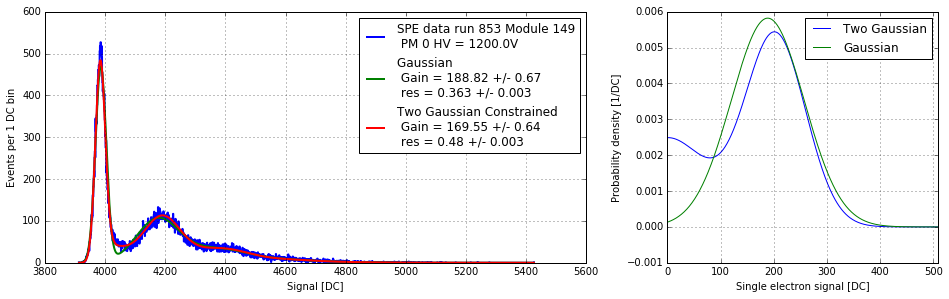

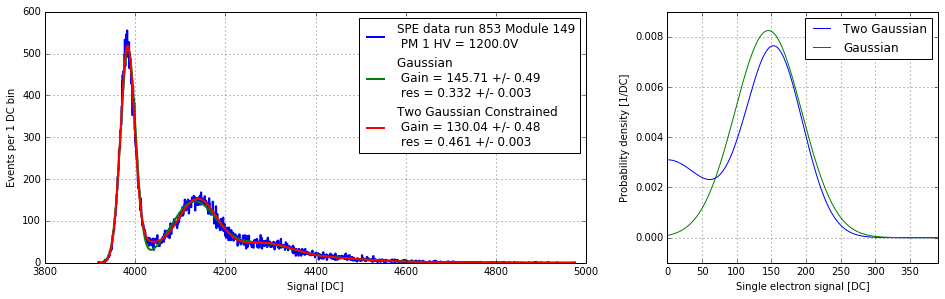

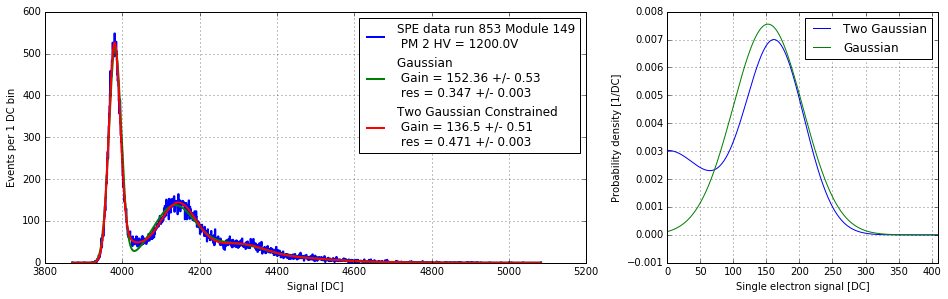

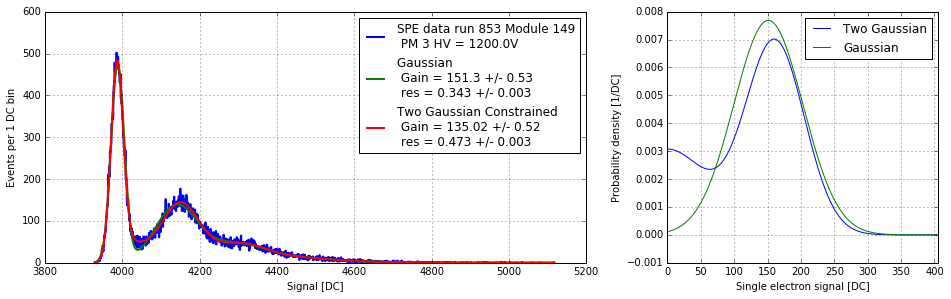

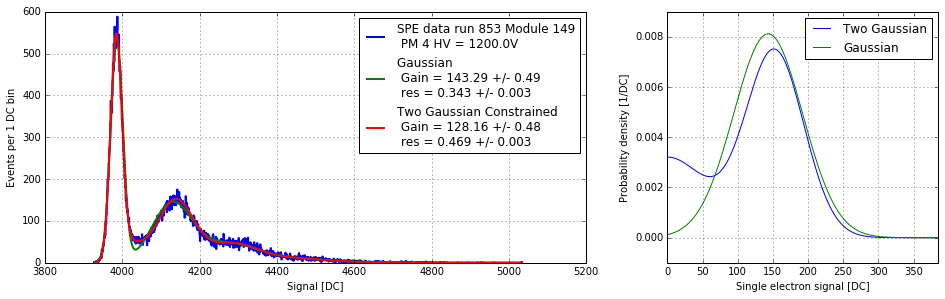

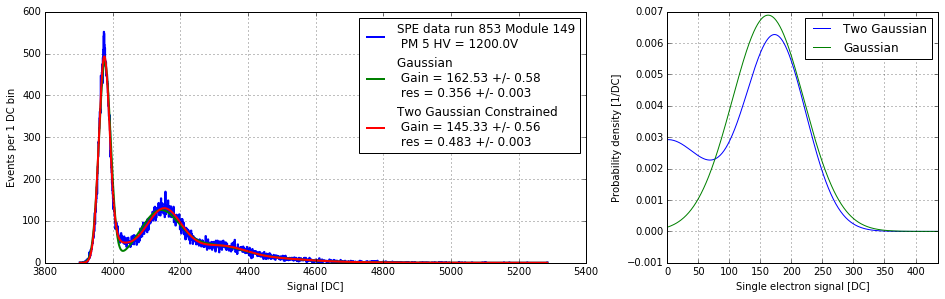

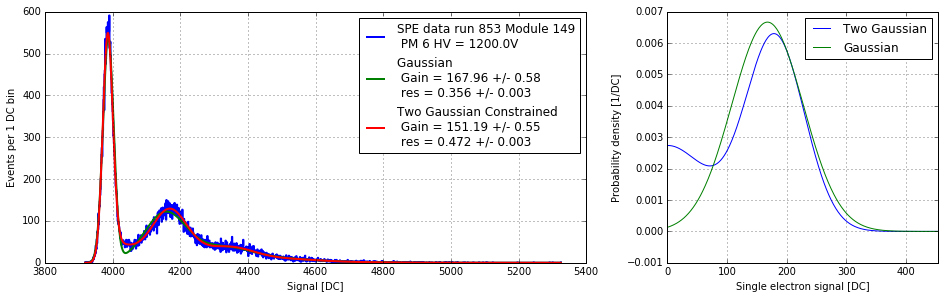

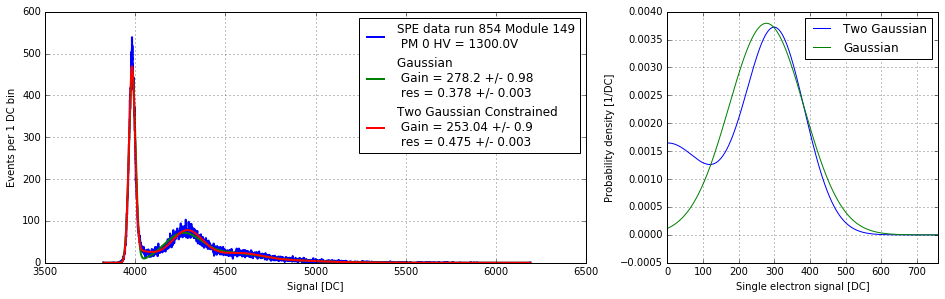

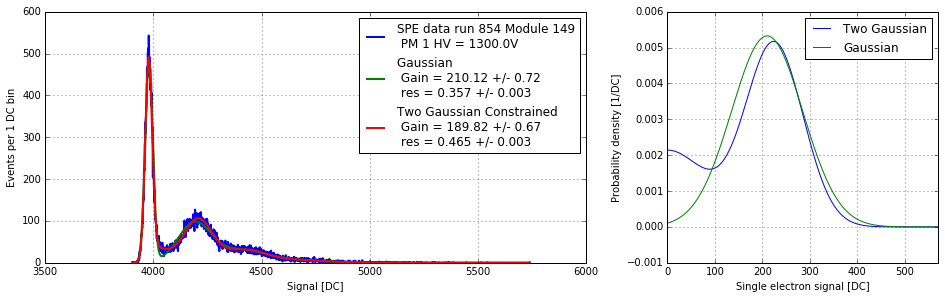

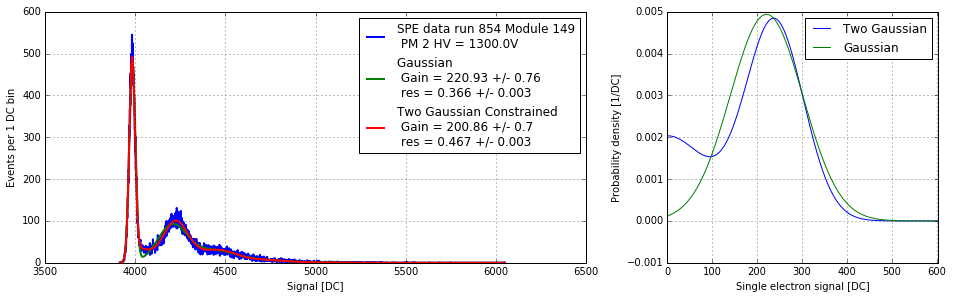

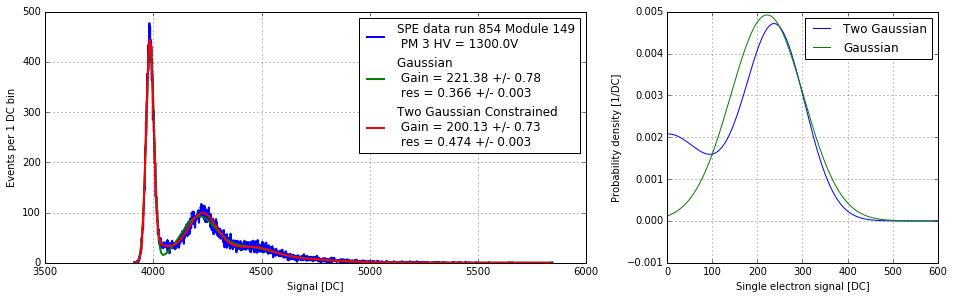

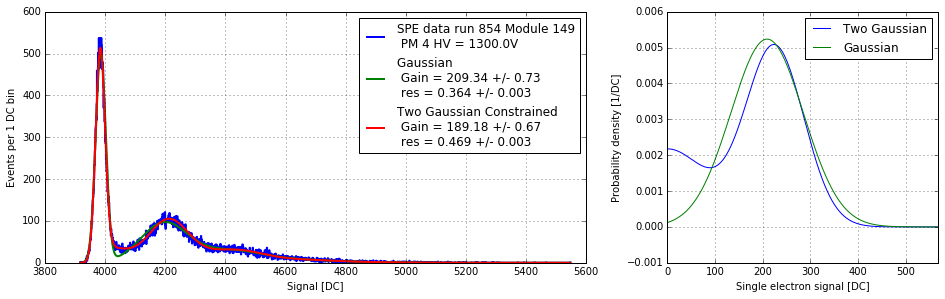

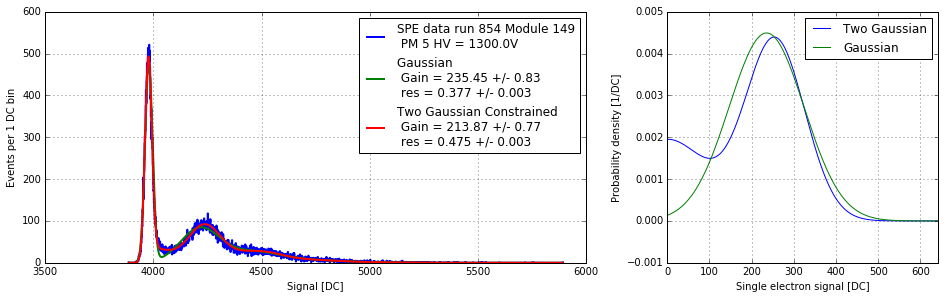

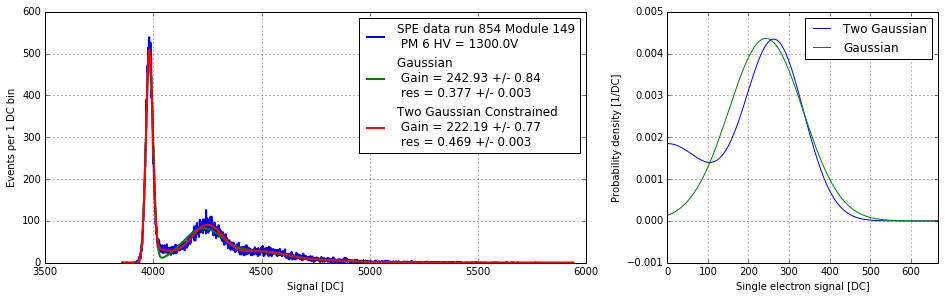

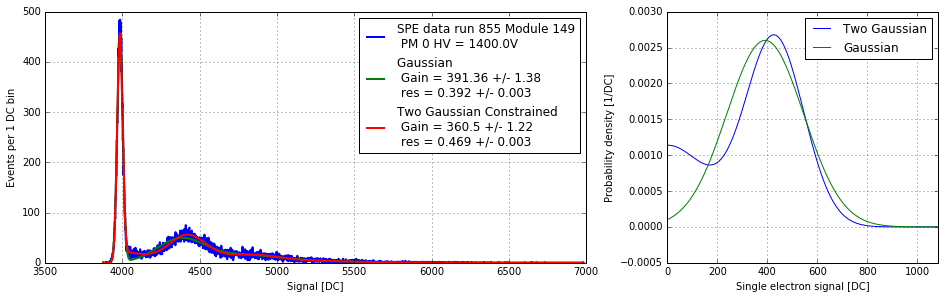

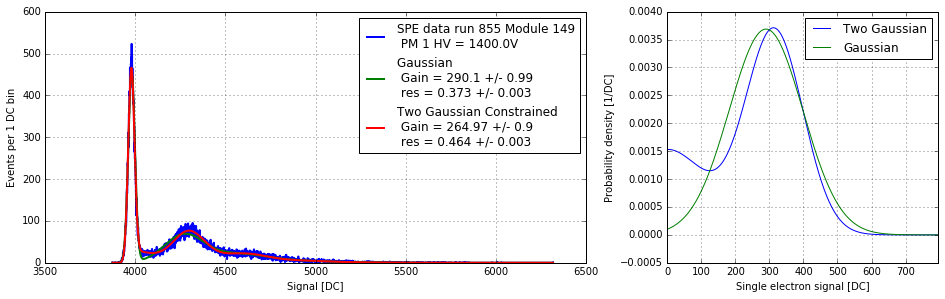

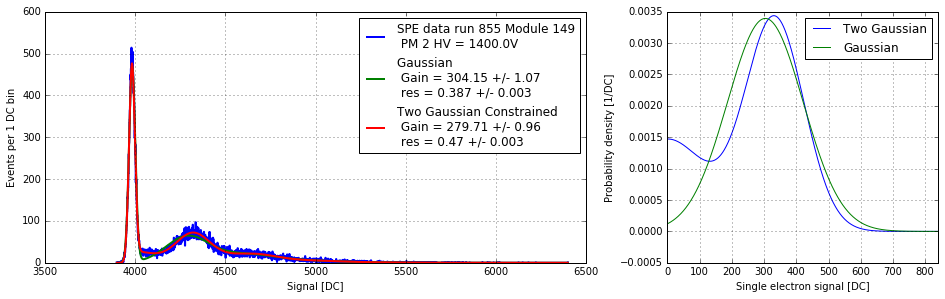

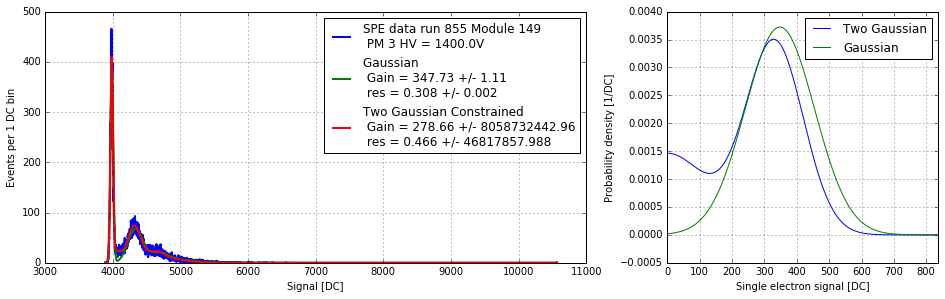

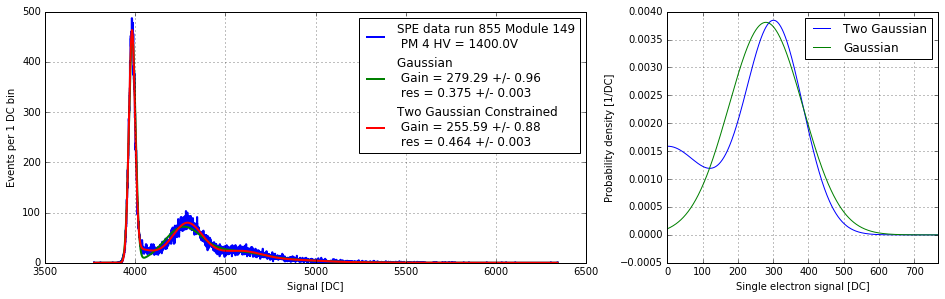

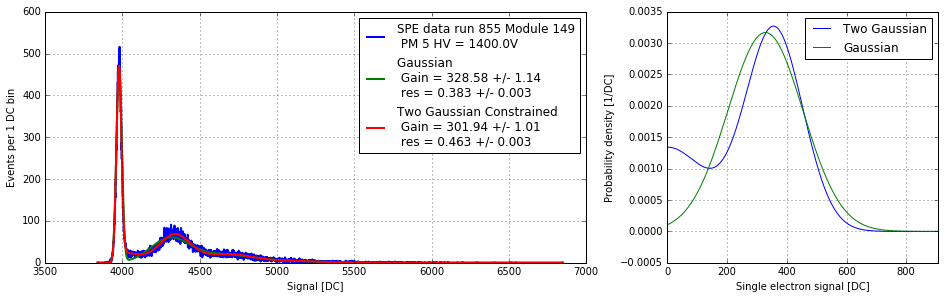

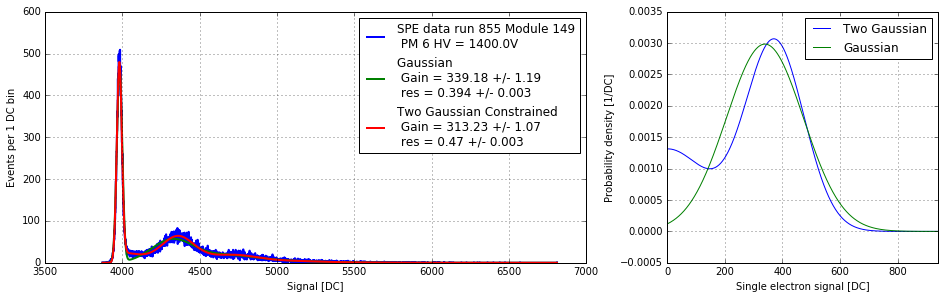

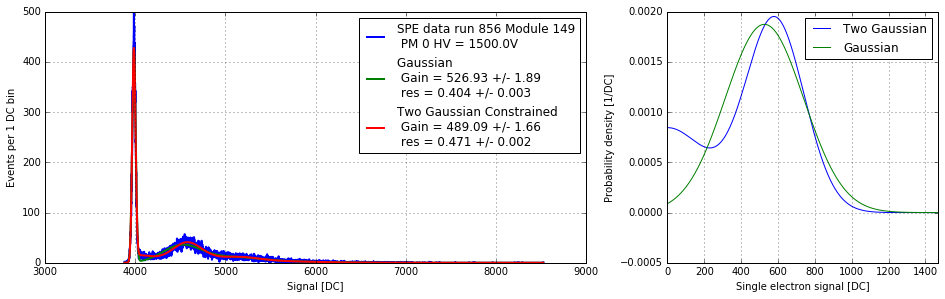

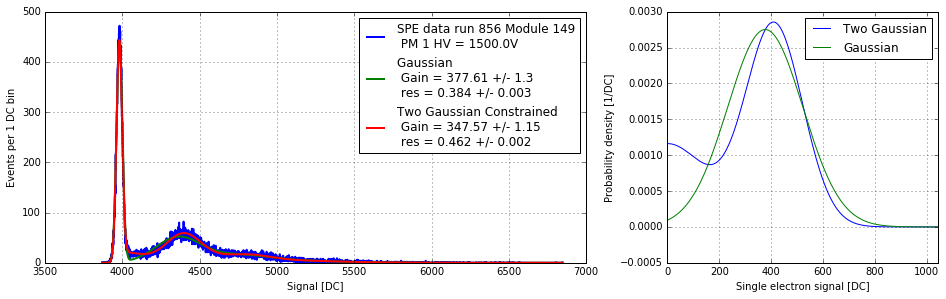

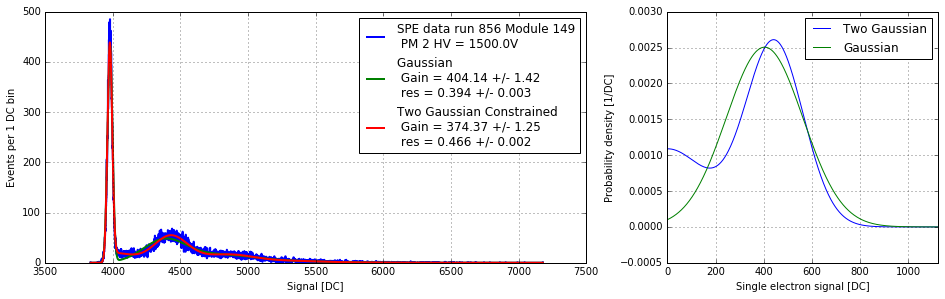

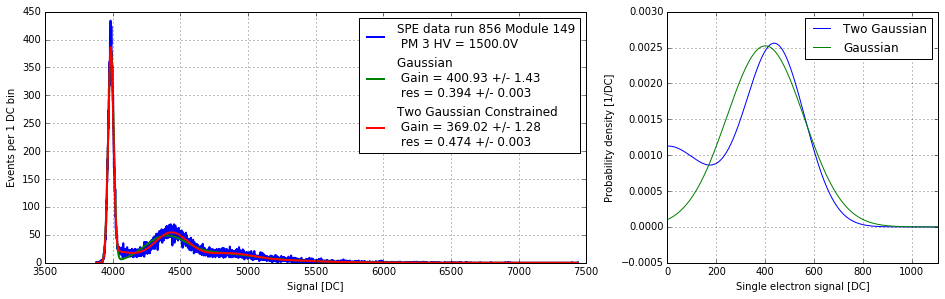

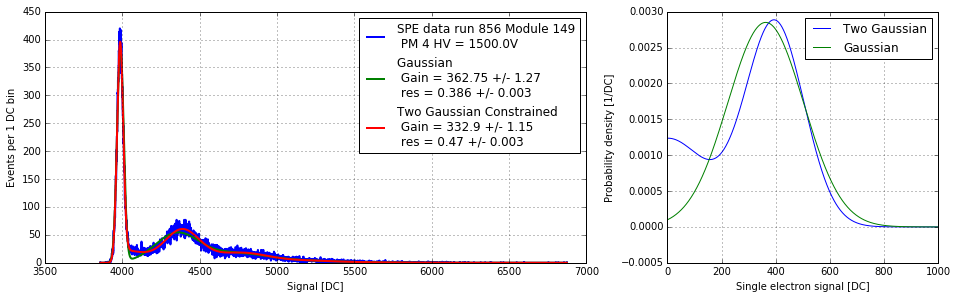

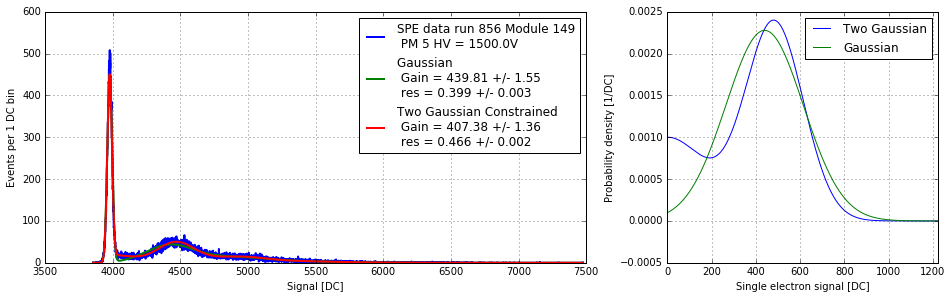

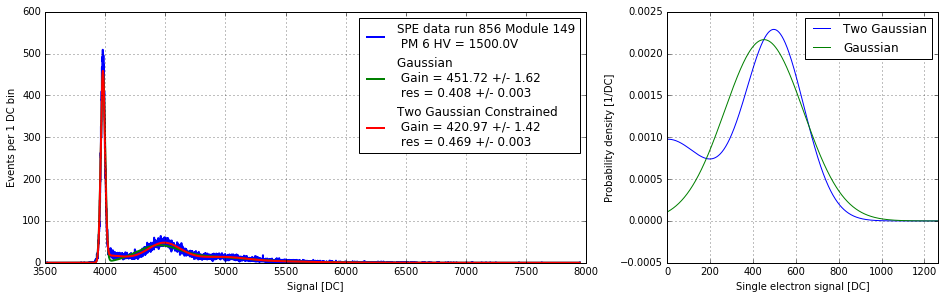

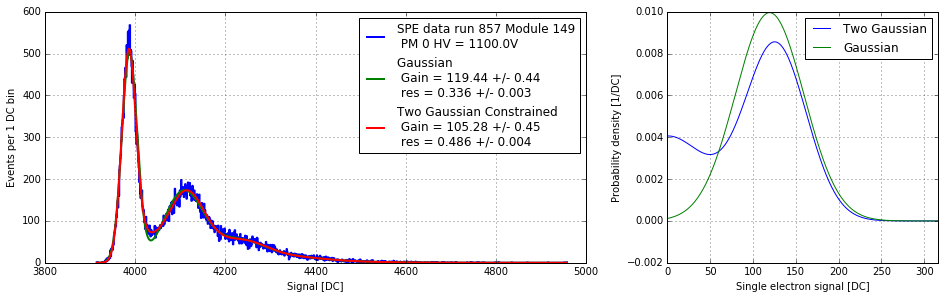

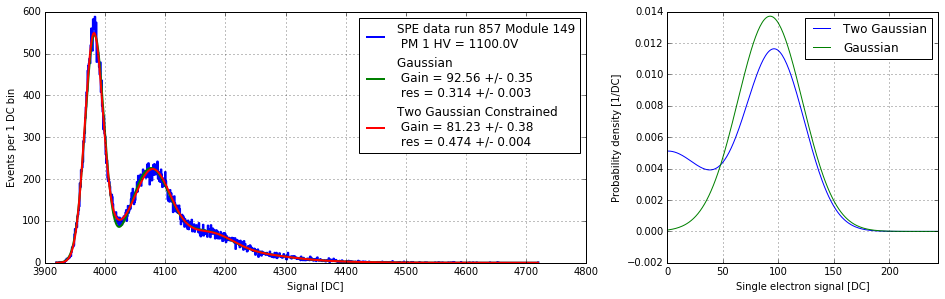

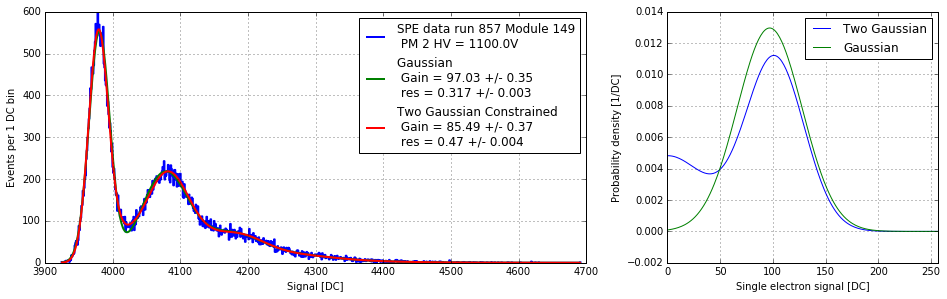

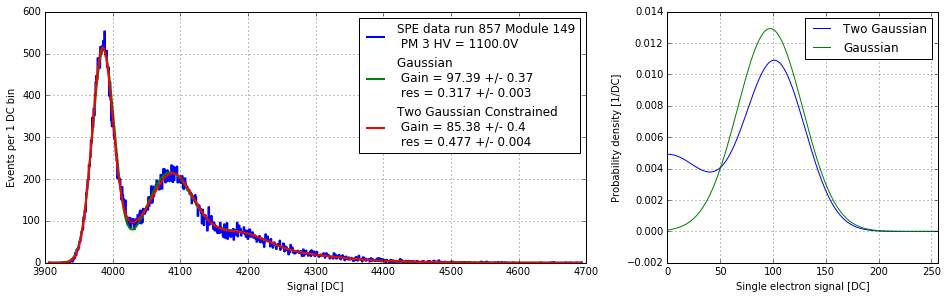

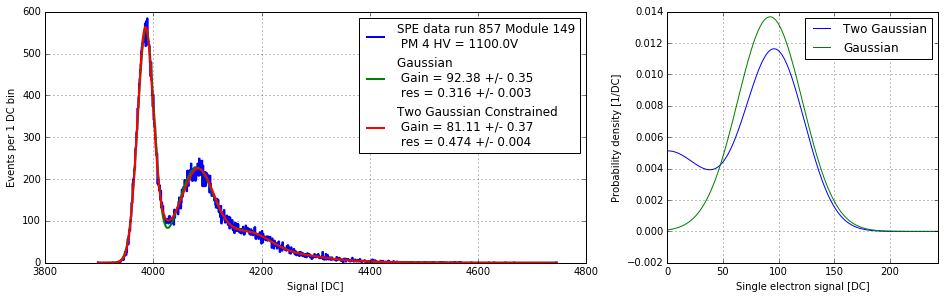

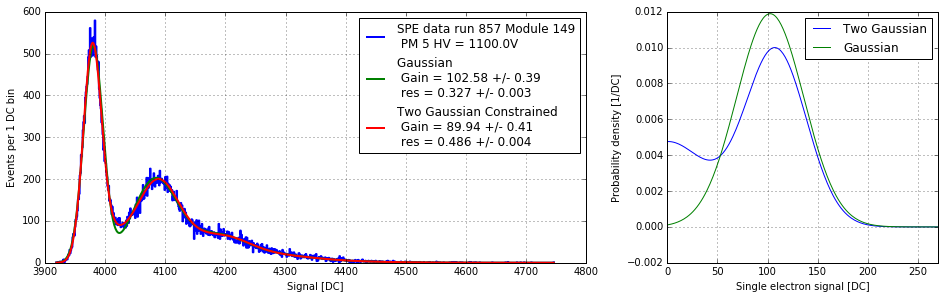

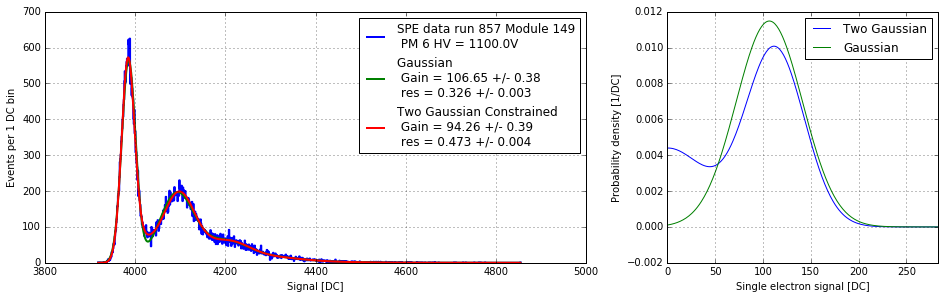

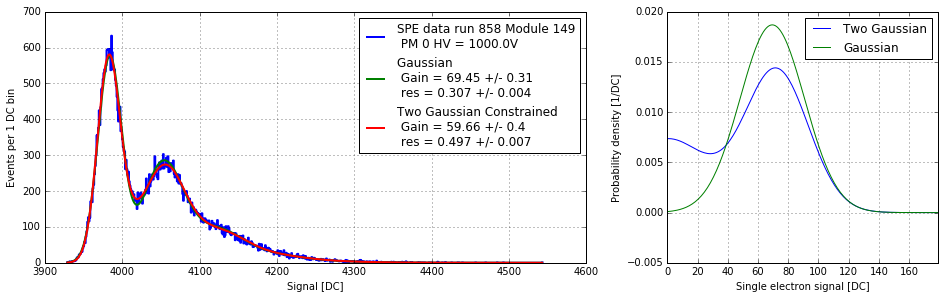

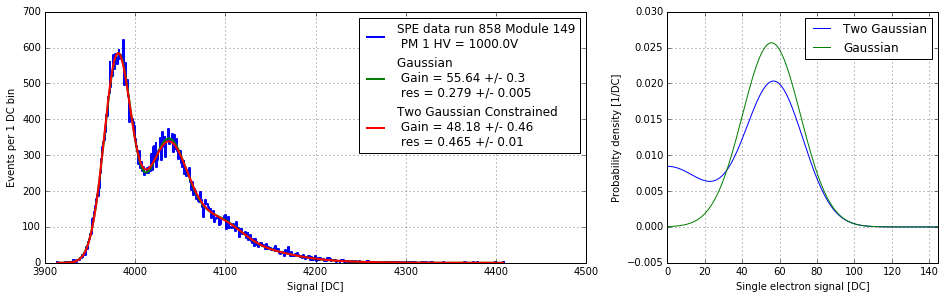

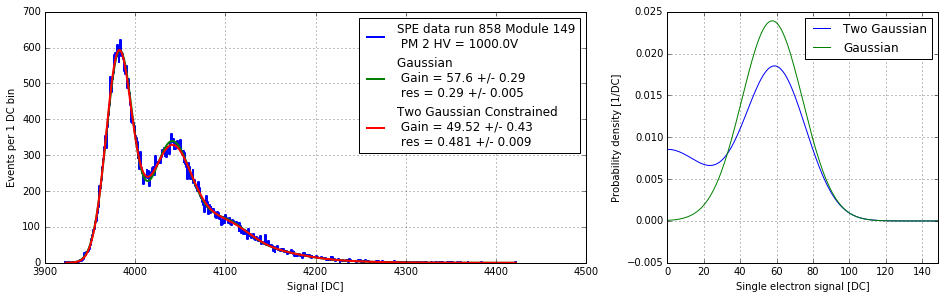

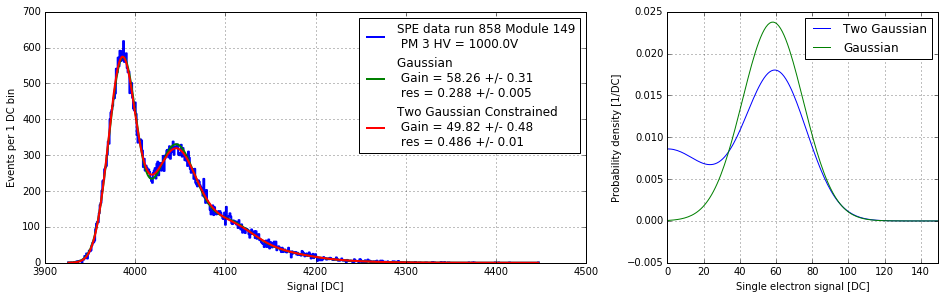

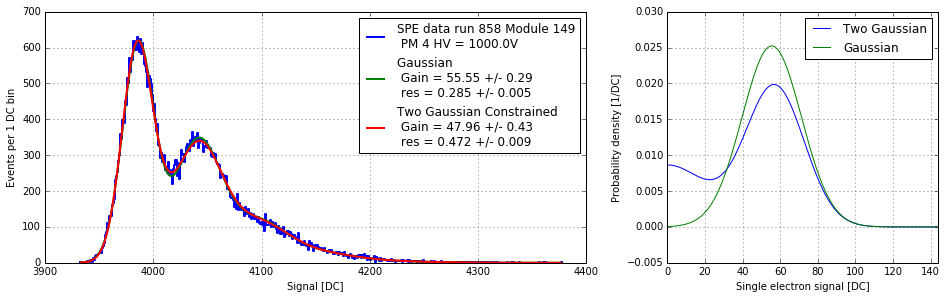

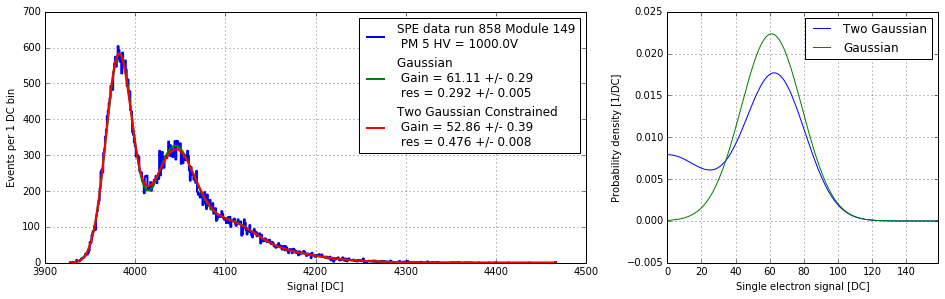

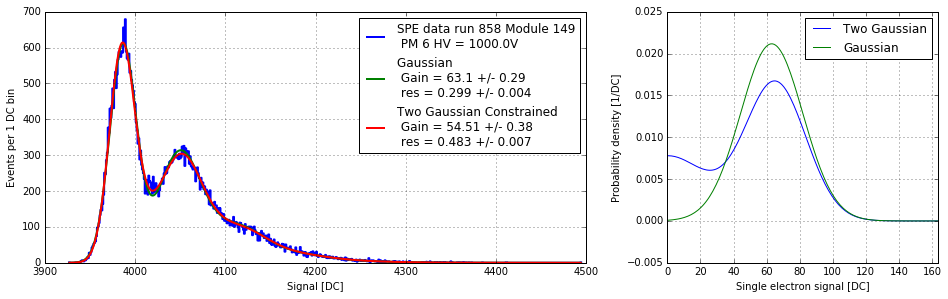

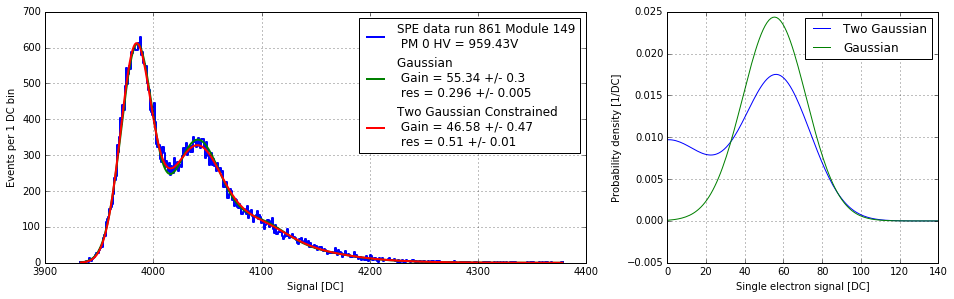

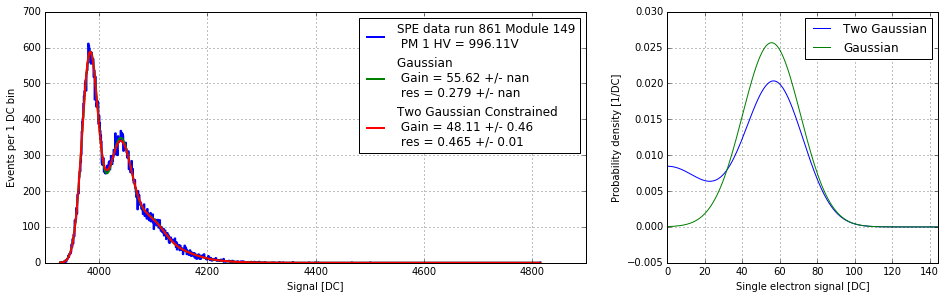

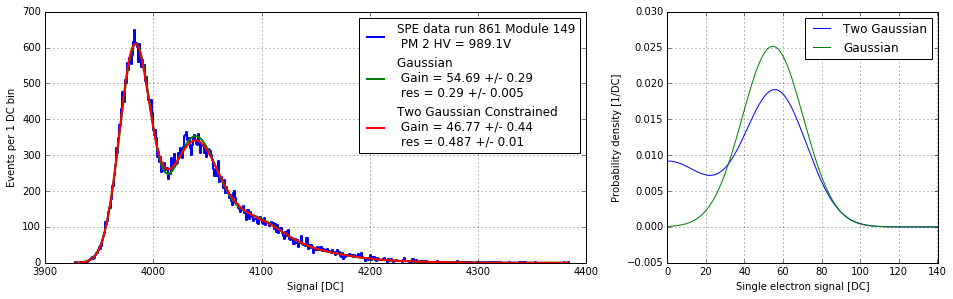

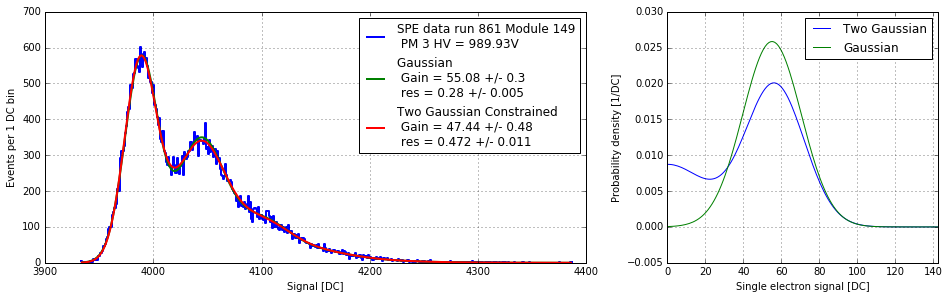

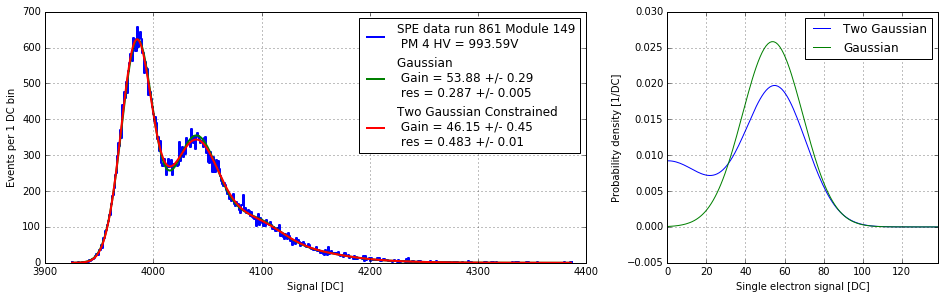

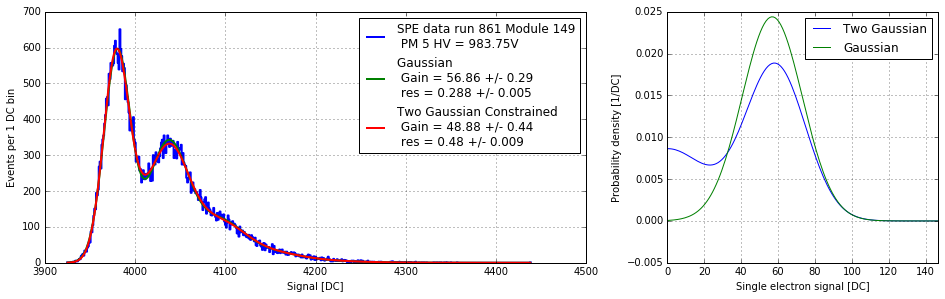

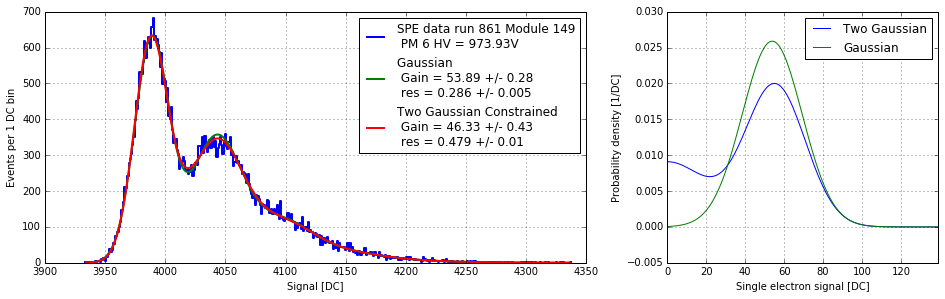

In [7]:
def PlotSPEFit(Histogram,pdf,results,runTable,Module,HVTable,DrawerTable,pdfG = 0, resultsG = 0, pdf2GRobust = 0, results2GRobust = 0):
    for i in range(0,len(Histogram)):
        figure(i, figsize=(16, 9))
        gs = gridspec.GridSpec(1, 2,
                       width_ratios=[2, 1], height_ratios=[1, 1])
        subplot(gs[0])
        #print(drawerList[int(i/7)])
        calin.plotting.plot_histogram(Histogram[i], lw=2, label='SPE data run ' + str(runTable[i]) + ' Module ' + str(DrawerTable[i]) + '\n PM ' + str(int(((i/7.)-int(i/7.)+0.01)*7)) + ' HV = ' + str(HVTable[i]) + 'V')
        xlabel('Signal [DC]')
        ylabel('Events per %d DC bin'%Histogram[i].dxval())

        ihist = range(0,Histogram[i].nbin());
        xhist = Histogram[i].all_xval_center()
        if (pdfG != 0 and resultsG != 0):
            pdfG[i].set_parameter_values(resultsG[i])
            ymodel_g = \
                list(map(lambda x: Histogram[i].sum_w()*Histogram[i].dxval()*pdfG[i].pdf_mes(x),xhist))
            plot(xhist,ymodel_g, label='Gaussian \n Gain = '+str(round(gainG[i],2))+' +/- ' + str(round(deltaGainG[i],2))+'\n res = '+str(round(ResolutionG[i],3))+' +/- ' + str(round(UncertaintyResolutionG[i],3)),linewidth=2.0)
        pdf[i].set_parameter_values(results[i])
        ymodel_2g = \
            list(map(lambda x: Histogram[i].sum_w()*Histogram[i].dxval()*pdf[i].pdf_mes(x),xhist))
        plot(xhist,ymodel_2g, label='Two Gaussian Constrained \n Gain = '+str(round(gain2G[i],2))+' +/- ' + str(round(deltaGain2G[i],2))+'\n res = '+str(round(Param2G[i][2],3))+' +/- ' + str(round(deltaParam2G[i][2],3)),linewidth=2.0)
        a=list(axis())
        if (pdf2GRobust != 0 and results2GRobust != 0):
            pdf2GRobust[i].set_parameter_values(results2GRobust[i])
            ymodel_g = \
                list(map(lambda x: Histogram[i].sum_w()*Histogram[i].dxval()*pdf2GRobust[i].pdf_mes(x),xhist))
            plot(xhist,ymodel_g, label='Two Gaussian Constrained (All parameters free) \n Gain = '+str(round(gain2GRobust[i],2))+' +/- ' + str(round(deltaGain2GRobust[i],2))+'\n res = '+str(round(Param2GRobust[i][2],3))+' +/- ' + str(round(deltaParam2GRobust[i][2],3)),linewidth=2.0)

        a=list(axis())
        #a[0] = -200
        #a[1] = 5000
        #a[2] = 0.0
        #a[3] = 100
        axis(a)
        legend()
        grid()
        
        subplot(gs[1])
        xlabel('Single electron signal [DC]')
        ylabel('Probability density [1/DC]')
        plot(pdf[i].all_ses_x(), pdf[i].single_electron_spectrum(), label="Two Gaussian")
        if (pdfG != 0 and resultsG != 0):
            plot(pdfG[i].all_ses_x(), pdfG[i].single_electron_spectrum(), label="Gaussian")
        if (pdf2GRobust != 0 and results2GRobust != 0):
            plot(pdf2GRobust[i].all_ses_x(), pdf2GRobust[i].single_electron_spectrum(), label="Two Gaussian (All parameters free)")
        a=list(axis())
        a[0] = 0
        a[1] = 3*sum(pdf[i].all_ses_x() * pdf[i].single_electron_spectrum())*Histogram[i].dxval()
        axis(a)
        legend()
        grid()
        

#PlotSPEFit(Histogram,mes2G,results2G,runTable,Module,mesG,resultsG,mes2GRobust,results2GRobust)
PlotSPEFit(Histogram,mes2G,results2G,runTable,Module,HVTable,DrawerTable,mesG,resultsG)



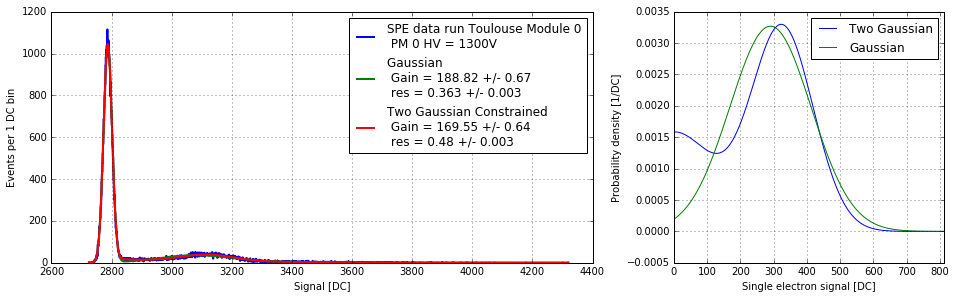

In [8]:
PlotSPEFit(DataListSignalToulouse,mes2GToulouse,results2GToulouse,["Toulouse"],["0"],["1300"],["0"],mesGToulouse,resultsGToulouse)

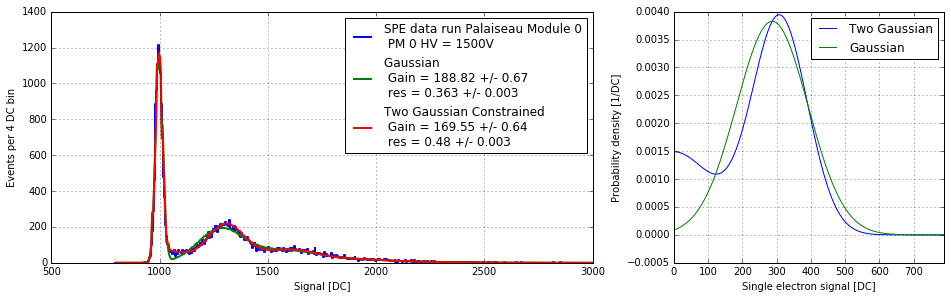

In [9]:
PlotSPEFit(DataListSignalPalaiseau,mes2GPalaiseau,results2GPalaiseau,["Palaiseau"],["0"],["1500"],["0"],mesGPalaiseau,resultsGPalaiseau)